# Transformer Prediction Model Diarrhoea Version 3
Date: 28/11/2022
Description: Transformer
Data: new data

In [1]:
# Install packages
!pip install -U scikit-learn
!pip install ftfy
# !pip install xlsxwriter 
# !pip install xlwt

In [2]:
# Imports
import tensorflow as tf 
# from google.colab import drive
import os

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense

import traceback
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
warnings.simplefilter("ignore", UserWarning)

plt.rcParams['figure.figsize'] = [7, 3]

import math

# Input path

In [3]:
# Attach Google Drive for reading and saving files
# drive.mount('/content/drive')
prj_path = '/home/mlworker/Quang/HealthCare/Source_14012023_v4/'
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/opt_results_12022023_v4/"
data_path = prj_path + "data/new_data/DH/squeezed/"

# result path 
path = prj_path + "results/results_14022023/"
path_metrix = path + 'metrix_tf/'
path_all_mix_cnn = path + 'all_mix_data/cnn/'
path_all_mix_lstm = path + 'all_mix_data/lstm/'
path_all_mix_lstm_att = path + 'all_mix_data/lstm_att/'

path_all_mix_tf= path + 'all_mix_data/tf/'

os.chdir(prj_path)

# Class Train and Support Functions for Preprocess

---



In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

In [5]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 24 tháng = 2 năm
        self.test_size = 24
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng 3 tháng
        self.n_predicted_month = 3
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.epochs = 300

args = Configuration()

# Pre-processing Functions

In [6]:
cities = [
    'An Giang', 
    'BR Vũng Tàu',
    'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
#         'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
#         'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
#         'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
#         'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
#         'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
#         'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La','TT Huế',
#         'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
#         'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
#          'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]



def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(data_path+'squeezed_'+city+'.xlsx')  
    # Đoạn này rất quan trọng. Optimize không được đụng vào 36 tháng (2015-2017) để dự báo. 
    # Lúc train và predict thì ok. Lấy từ 1997 -2017. 
    # Function split data sẽ lấy 3 năm cuối làm test data theo config     
    city_result = city_result.loc[city_result['year_month'] < '2015-1-1'] 
    cities_data[city] = city_result
  return cities_data

dict_full_data = get_dict_all_city_data()

In [7]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name):
    """Returns Diarrhoea rate and climate data only""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                                        'Influenza_rates','Dengue_fever_rates',
                                                        'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                                        'population_male','population_female','population_urban',
                                                        'population_countryside','area','population_density',
                                                        'population_average','birth_rate','urban_water_usage_rate',
                                                        'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data


def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Cơ bản dữ liệu bị thiếu sót rất nhiều: Như Điện Biên 1997 -2003 là thiếu dữ liệu về bệnh
    Hàm này sẽ tự sinh ra dữ liệu bị thiếu. Nếu tháng nào không có số liệu thì tính như sau:
    12 tháng đầu không có số liệu thì gán = 0
    tháng 13-24 không có số liệu, sẽ lấy giá trị của tháng cùng kỳ năm trước
    tháng từ 24 trở đi sẽ lấy giá trị nhỏ nhất của 2 tháng cùng kỳ trong 2 năm gần nhất.
    Do Điện Biên bằng 0 nên sau khi xử lý từ 1997 -2003 là đều = 0.  
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [8]:
# dict_full_data['Tiền Giang']
# city_TienGiang = get_city_data('Tiền Giang')

In [9]:
def split_data(data, look_back ):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]
    print('lookback', look_back)
    test = data[-args.test_size - look_back: ]
    return train, test

In [10]:
def to_supervised(data, d_in=args.look_back, d_out=args.n_predicted_month, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [11]:
def select_feature(train, specific_data):
    """Selects args.n_features top features using RFE"""
    train_X, train_y = to_supervised(train, d_in=1, d_out=1)
    train_X, train_y = np.squeeze(train_X), np.squeeze(train_y)
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=args.seed), n_features_to_select=args.n_features)
    fit = rfe.fit(train_X, train_y)
    important_features = list()
    print("Important Feature:")
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            important_features.append(i)
            print(specific_data.columns[i])
    return np.array(important_features)

In [12]:
def get_data(train_np, test_np, batch_size, specific_data):
    """
    Returns important feature list and data formatted for input into Pytorch 
    models
    """
    important_features = select_feature(train_np, specific_data)

    train_X, train_y = to_supervised(train_np, features_list=important_features)
    test_X, test_y = to_supervised(test_np, features_list=important_features)
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

    return important_features, train_loader, test_tensor

In [13]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_month)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_month)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

In [14]:
# Transformer Model
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=3, n_feature=3, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(n_feature, d_model)
        for pos in range(n_feature):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                if i + 1 < d_model:
                    pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.d_model)
        length = x.size(1)
        pe = Variable(self.pe[:, :length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_input, n_head, hidden_size, n_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.pe = PositionalEncoder(dropout=dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_input*n_head, args.n_predicted_month)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
        self.loss_fn = nn.MSELoss()
    
    def forward(self, X_batch, y_batch=None):
        X_batch = self.pe(X_batch)
        X_batch = self.transformer_encoder(X_batch)
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        y_predicted = self.decoder(X_batch)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
        else:
            return y_predicted
        return X_batch
    
    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, device=args.device)
        return self.forward(X).squeeze()

In [15]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, city, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type    
        self.city = city    
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout, city)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout, city):
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        if model_type.lower() == 'lstm':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'lstm_attention':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'cnn':
            model = MultivariateCNN(num_filters, dropout)
        elif model_type.lower() == 'transformers':
            model = TransformerModel(d_input=args.look_back, n_head=3, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)   
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None



    # Lưu model vào trong thư mục models
    def save_model_to(self, path = '', city =''):       
        torch.save(self.model, path)

    def load_model_to(self, path = ''):       
        return torch.load(path)

    def evaluate_model(self, np_data=None, plot=True, scaled=True, city=None, k_steps=None, y_scaler =None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data)
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        for k_steps in range(1, args.n_predicted_month + 1):
            y_predicted = []
            y_true = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, self.important_features]
                # yhat = self.model.predict(X.unsqueeze(0)).squeeze()

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
                y_true.append(tensor_data[index + args.look_back, -1].detach().cpu().numpy())

            y_predicted = y_scaler.inverse_transform(np.array(y_predicted).reshape(-1, 1)).reshape(-1, )
            y_true = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).reshape(-1, )

            

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            print('City: '+self.city+'  _algo:'+self.model_type+'  -MAE: '+str(mae))          
            if plot==True:
              plt.grid(True)
              plt.plot(y_predicted, label='predicted')
              plt.plot(y_true, label='actual')
              plt.title(f"k-steps = {k_steps} - city: "+self.city+'  _algo:'+self.model_type+'  -MAE: '+str(mae))
              plt.legend()
              plt.show()
                
            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

In [16]:
def convert_str_num_filter_array(str_filter = ''):  
  arr_filter = str_filter.split(',')  
  int_arr_filter= [int(x) for x in arr_filter]
  return int_arr_filter

# Get Optimized HyperParam

In [17]:

# prj_path_opt= '/content/drive/MyDrive/HealthCare/Source/optimize_hyperparam/opt_results/'
# opt_param_cnn = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_cnn.xlsx', index_col = 'City')
# opt_param_lstm = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_lstm.xlsx', index_col = 'City')
# opt_param_lstm_att = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_lstm_att.xlsx', index_col = 'City')
opt_param_transformer = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_transformer.xlsx', index_col = 'City')

def get_opt_param_by_name(algo = 'transformer', city = None):
  # if algo == 'cnn':
  #   city_param = opt_param_cnn.loc[city]
  #   #load  param
  #   n_layers = ''
  #   hidden_size = ''
  #   num_filters = convert_str_num_filter_array(city_param['Num. filters'])
  #   dropout = float(city_param['Dropout rate'])
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  # elif algo == 'lstm':
  #   city_param = opt_param_lstm.loc[city]
  #   #load  param
  #   n_layers = int(city_param['n Layers'])
  #   hidden_size = int(city_param['Hiden Size'])
  #   num_filters = ''
  #   dropout = ''
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  # elif algo == 'lstm_attention':
  #   city_param = opt_param_lstm_att.loc[city]
  #   #load  param
  #   n_layers = int(city_param['n Layers'])
  #   hidden_size = int(city_param['Hiden Size'])
  #   num_filters = ''
  #   dropout = ''
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  if algo == 'transformer':
    city_param = opt_param_transformer.loc[city]
    #load  param
    n_layers = int(city_param['n Layers'])
    hidden_size = int(city_param['Hidden Size'])
    num_filters = ''
    dropout = float(city_param['Dropout rate'])
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  return n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window


In [18]:
# Manual Check param before train
# n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window= get_opt_param_by_name(algo='transformer', city='Cao Bằng')
# lookback_window,epoch, hidden_size, n_layers,learning_rate, num_filters, dropout

# Mix Result và Lưu vào folder tương ứng theo từng algo

In [19]:
def mix_results(city, algo, specific_data, y_pred_test, y_pred_train, lookback_window, iteration, rmse, mae, mape):
    new_cols = ["City","Algorithm","Run Seq","Observed","Train Prediction","Test Prediction","rmse","mae","mape"]
    mix_train_test_result = pd.DataFrame()
    mix_train_test_result['Observed']= specific_data['Diarrhoea_rates'] #default lenght 239
    mix_train_test_result = mix_train_test_result.reset_index(drop=True)  
    mix_train_test_result['City'] = city
    mix_train_test_result['Algorithm'] = algo
    mix_train_test_result['Run Seq'] = iteration 
    mix_train_test_result['Train Prediction'] = None
    mix_train_test_result['Test Prediction'] = None
    mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
    mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
    mix_train_test_result['rmse'] = rmse
    mix_train_test_result['mae'] = mae
    mix_train_test_result['mape'] = mape
    mix_train_test_result= mix_train_test_result.reindex(columns=new_cols)
    return mix_train_test_result

In [20]:
def save_results(all_mix_train_test_result, algo,city):
  if algo == 'cnn':  
    all_mix_train_test_result.to_excel(path_all_mix_cnn+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'lstm':
    all_mix_train_test_result.to_excel(path_all_mix_lstm+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'lstm_att':
    all_mix_train_test_result.to_excel(path_all_mix_lstm_att+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'tf':
    all_mix_train_test_result.to_excel(path_all_mix_tf+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)


# Transformer train and run

lookback 3
Important Feature:
Total_Rainfall
Average_temperature
Diarrhoea_rates
An Giang
Epoch:  0/100 - train_loss: 1.0647 - test_loss: 0.808410
Epoch: 25/100 - train_loss: 0.2821 - test_loss: 0.218029
Epoch: 50/100 - train_loss: 0.2799 - test_loss: 0.225996
Epoch: 75/100 - train_loss: 0.2775 - test_loss: 0.226343
Epoch: 99/100 - train_loss: 0.2790 - test_loss: 0.237887
Evaluate on test set: 
City: An Giang  _algo:transformers  -MAE: 60.43078465234546


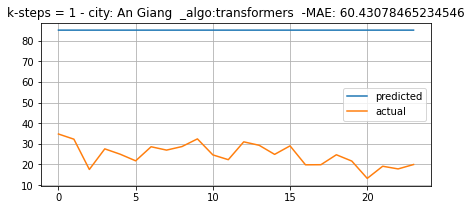

City: An Giang  _algo:transformers  -MAE: 59.86201750253971


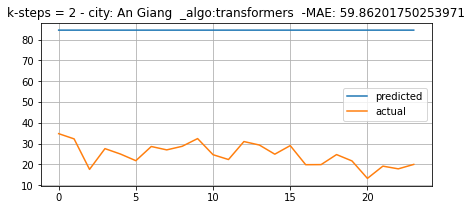

City: An Giang  _algo:transformers  -MAE: 62.8614797647667


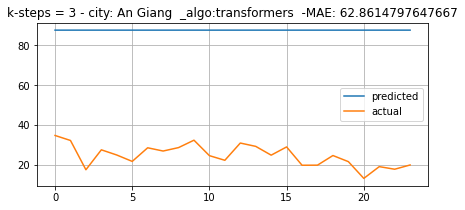

Evaluate on train set: 
City: An Giang  _algo:transformers  -MAE: 56.368533408788494


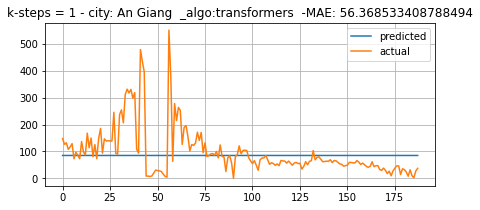

City: An Giang  _algo:transformers  -MAE: 56.23217002525722


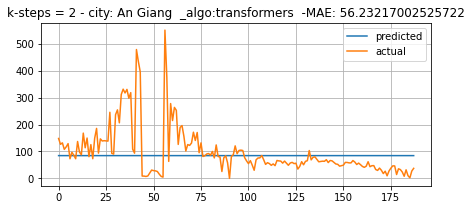

City: An Giang  _algo:transformers  -MAE: 56.99309457583503


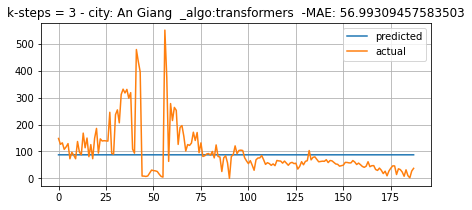

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Total_Rainfall
Average_temperature
Diarrhoea_rates
An Giang
Epoch:  0/100 - train_loss: 0.8968 - test_loss: 0.737149
Epoch: 25/100 - train_loss: 0.2872 - test_loss: 0.235268
Epoch: 50/100 - train_loss: 0.2769 - test_loss: 0.210726
Epoch: 75/100 - train_loss: 0.2804 - test_loss: 0.235511
Epoch: 99/100 - train_loss: 0.2825 - test_loss: 0.209030
Evaluate on test set: 
City: An Giang  _algo:transformers  -MAE: 61.76080630524918


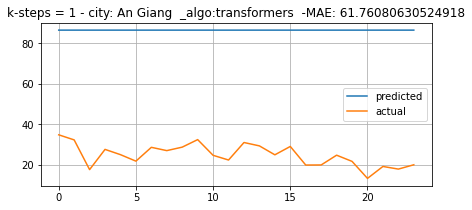

City: An Giang  _algo:transformers  -MAE: 65.21113489071683


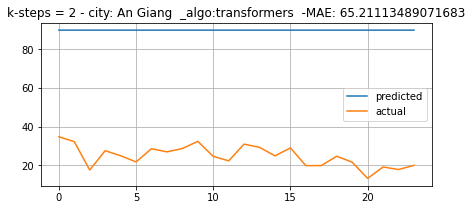

City: An Giang  _algo:transformers  -MAE: 64.45202775903331


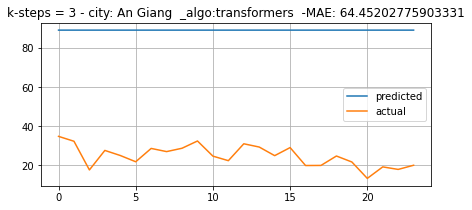

Evaluate on train set: 
City: An Giang  _algo:transformers  -MAE: 56.70066622130026


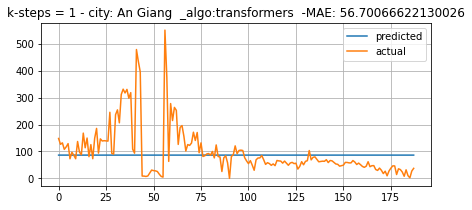

City: An Giang  _algo:transformers  -MAE: 57.66213008759437


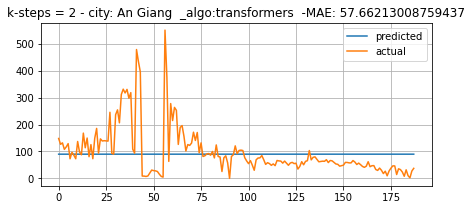

City: An Giang  _algo:transformers  -MAE: 57.4441523607268


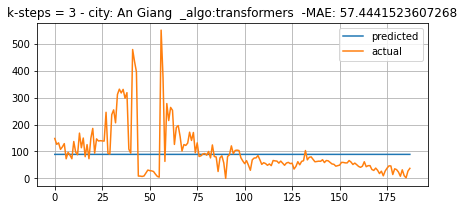

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_temperature
Diarrhoea_rates
An Giang
Epoch:  0/100 - train_loss: 0.8938 - test_loss: 0.711220
Epoch: 25/100 - train_loss: 0.2844 - test_loss: 0.250900
Epoch: 50/100 - train_loss: 0.2762 - test_loss: 0.214257
Epoch: 75/100 - train_loss: 0.2756 - test_loss: 0.226629
Epoch: 99/100 - train_loss: 0.2807 - test_loss: 0.226477
Evaluate on test set: 
City: An Giang  _algo:transformers  -MAE: 62.440737215478435


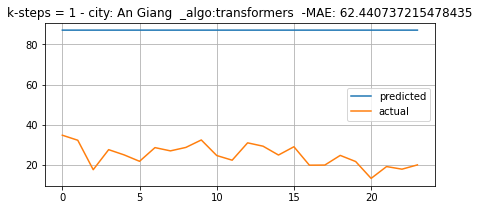

City: An Giang  _algo:transformers  -MAE: 65.44826654887355


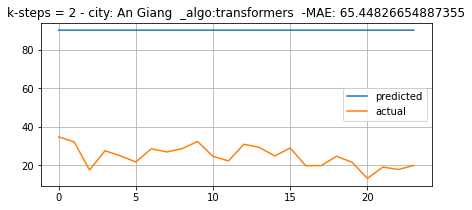

City: An Giang  _algo:transformers  -MAE: 62.42723812038884


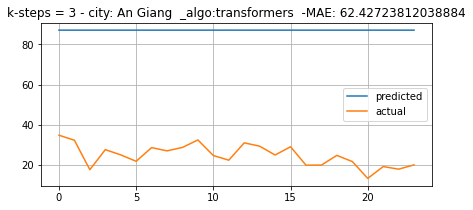

Evaluate on train set: 
City: An Giang  _algo:transformers  -MAE: 56.88119168554365


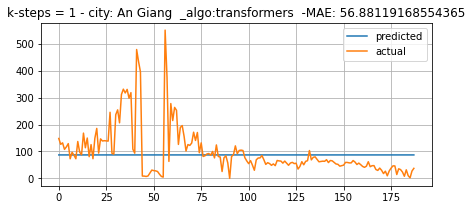

City: An Giang  _algo:transformers  -MAE: 57.73041374495766


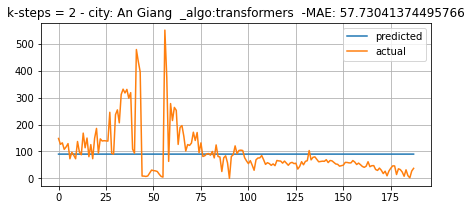

City: An Giang  _algo:transformers  -MAE: 56.87735772327254


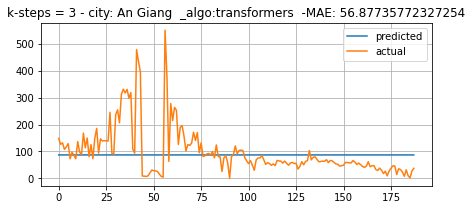

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_temperature
Diarrhoea_rates
An Giang
Epoch:  0/100 - train_loss: 1.1872 - test_loss: 1.208994
Epoch: 25/100 - train_loss: 0.2884 - test_loss: 0.216656
Epoch: 50/100 - train_loss: 0.2847 - test_loss: 0.244009
Epoch: 75/100 - train_loss: 0.2782 - test_loss: 0.211786
Epoch: 99/100 - train_loss: 0.2771 - test_loss: 0.194081
Evaluate on test set: 
City: An Giang  _algo:transformers  -MAE: 64.9565016773683


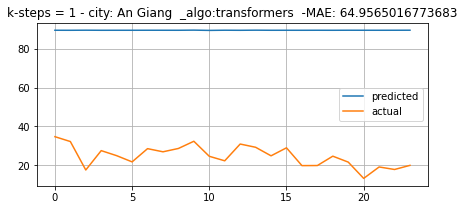

City: An Giang  _algo:transformers  -MAE: 59.01674102298762


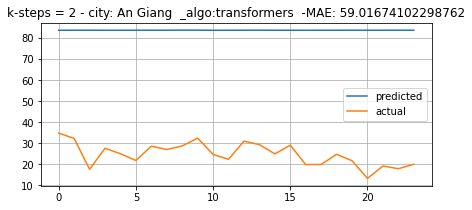

City: An Giang  _algo:transformers  -MAE: 62.421277839819474


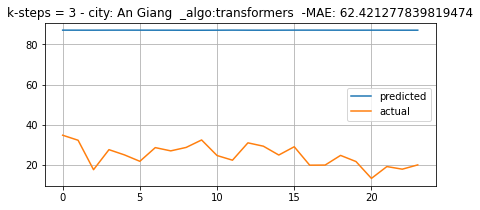

Evaluate on train set: 
City: An Giang  _algo:transformers  -MAE: 57.50351789278316


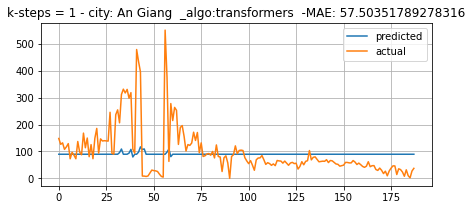

City: An Giang  _algo:transformers  -MAE: 55.876711607528705


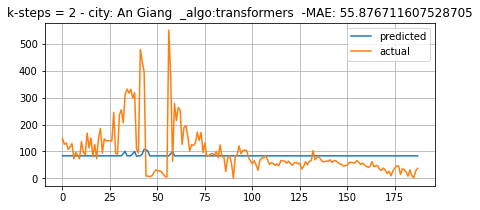

City: An Giang  _algo:transformers  -MAE: 56.74100007409859


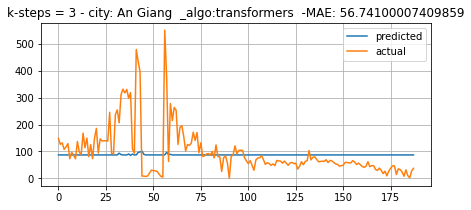

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_temperature
Diarrhoea_rates
An Giang
Epoch:  0/100 - train_loss: 0.9675 - test_loss: 0.724889
Epoch: 25/100 - train_loss: 0.2904 - test_loss: 0.233473
Epoch: 50/100 - train_loss: 0.2788 - test_loss: 0.234796
Epoch: 75/100 - train_loss: 0.2775 - test_loss: 0.229641
Epoch: 99/100 - train_loss: 0.2801 - test_loss: 0.214985
Evaluate on test set: 
City: An Giang  _algo:transformers  -MAE: 60.69662276936566


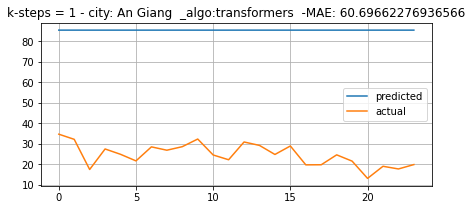

City: An Giang  _algo:transformers  -MAE: 61.231223525342955


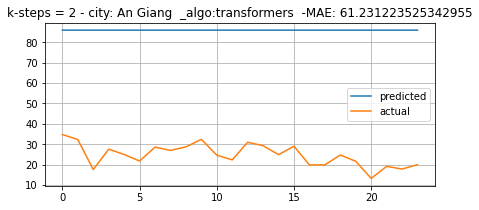

City: An Giang  _algo:transformers  -MAE: 72.70773016987503


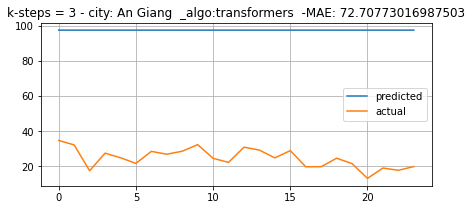

Evaluate on train set: 
City: An Giang  _algo:transformers  -MAE: 56.4335834021677


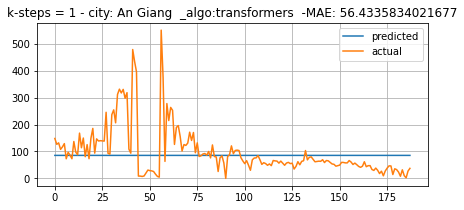

City: An Giang  _algo:transformers  -MAE: 56.564033815121164


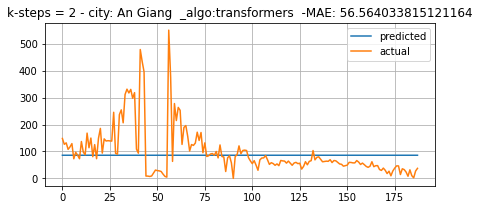

City: An Giang  _algo:transformers  -MAE: 60.231428090757056


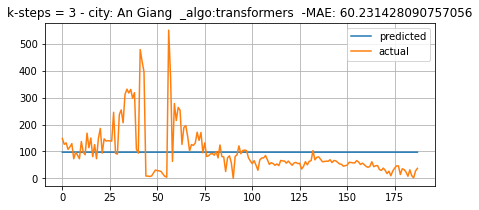

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
BR Vũng Tàu
Epoch:  0/170 - train_loss: 1.3270 - test_loss: 0.826294
Epoch: 42/170 - train_loss: 0.7726 - test_loss: 0.571293
Epoch: 84/170 - train_loss: 0.5135 - test_loss: 0.387103
Epoch: 126/170 - train_loss: 0.3342 - test_loss: 0.266557
Epoch: 168/170 - train_loss: 0.2436 - test_loss: 0.183536
Epoch: 169/170 - train_loss: 0.2413 - test_loss: 0.181885
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 11.964665028871346


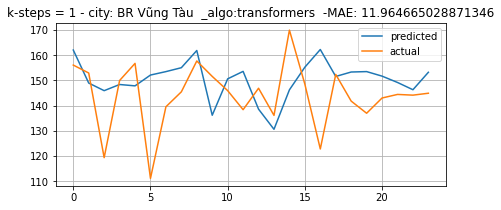

City: BR Vũng Tàu  _algo:transformers  -MAE: 19.833814029404227


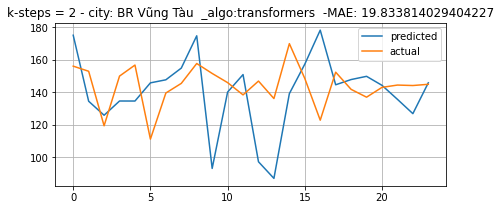

City: BR Vũng Tàu  _algo:transformers  -MAE: 14.975149742565728


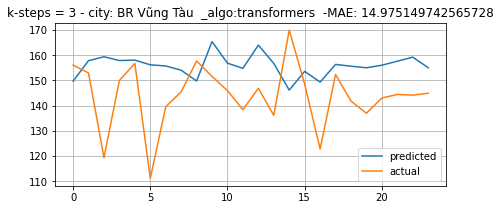

Evaluate on train set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 42.16921528077136


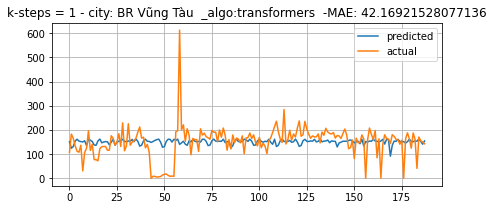

City: BR Vũng Tàu  _algo:transformers  -MAE: 46.87898709586947


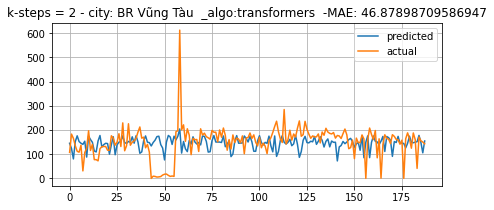

City: BR Vũng Tàu  _algo:transformers  -MAE: 41.25873423473491


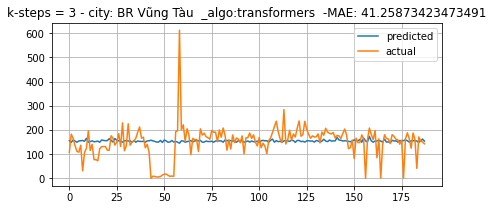

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
BR Vũng Tàu
Epoch:  0/170 - train_loss: 1.2206 - test_loss: 1.020487
Epoch: 42/170 - train_loss: 0.6431 - test_loss: 0.540610
Epoch: 84/170 - train_loss: 0.4700 - test_loss: 0.393580
Epoch: 126/170 - train_loss: 0.3328 - test_loss: 0.284398
Epoch: 168/170 - train_loss: 0.2648 - test_loss: 0.203809
Epoch: 169/170 - train_loss: 0.2547 - test_loss: 0.202137
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 13.501264674681627


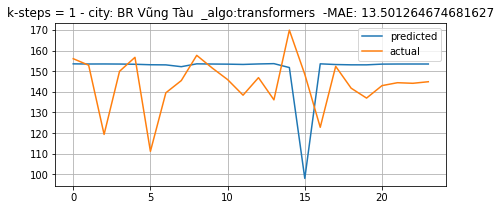

City: BR Vũng Tàu  _algo:transformers  -MAE: 16.122934334750223


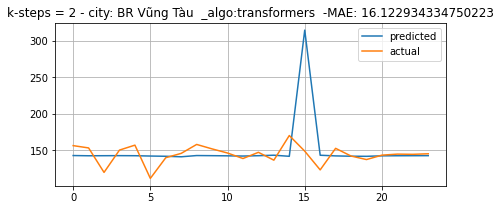

City: BR Vũng Tàu  _algo:transformers  -MAE: 13.696704350173613


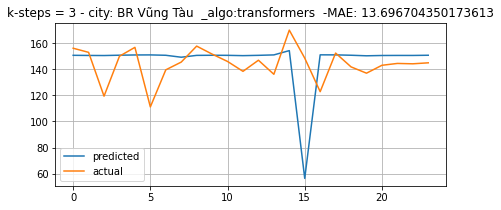

Evaluate on train set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 41.543236871869794


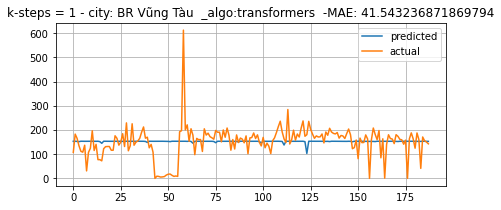

City: BR Vũng Tàu  _algo:transformers  -MAE: 44.58832495619063


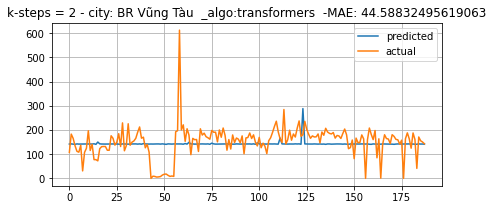

City: BR Vũng Tàu  _algo:transformers  -MAE: 42.27859577138107


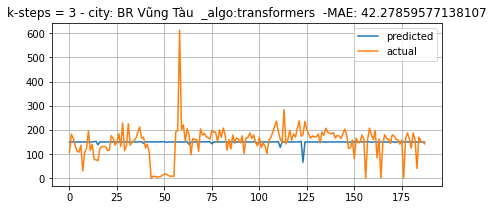

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
BR Vũng Tàu
Epoch:  0/170 - train_loss: 1.4967 - test_loss: 1.695848
Epoch: 42/170 - train_loss: 0.8878 - test_loss: 1.020103
Epoch: 84/170 - train_loss: 0.5179 - test_loss: 0.494034
Epoch: 126/170 - train_loss: 0.3130 - test_loss: 0.269937
Epoch: 168/170 - train_loss: 0.2288 - test_loss: 0.172869
Epoch: 169/170 - train_loss: 0.2302 - test_loss: 0.170887
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 11.420500100694673


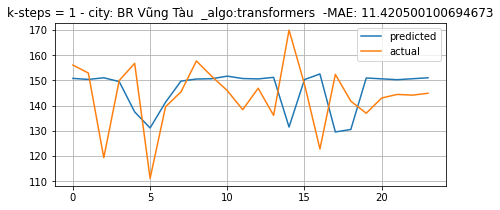

City: BR Vũng Tàu  _algo:transformers  -MAE: 16.32863999079197


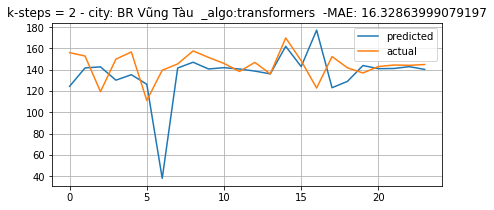

City: BR Vũng Tàu  _algo:transformers  -MAE: 26.44278401595606


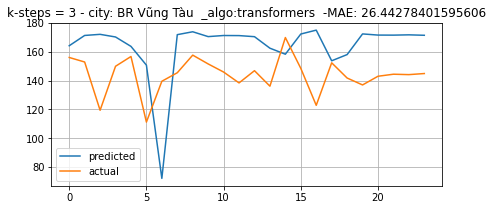

Evaluate on train set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 42.55211126177766


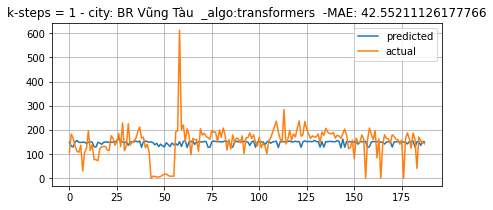

City: BR Vũng Tàu  _algo:transformers  -MAE: 50.19602598345427


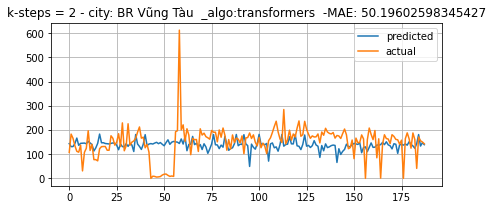

City: BR Vũng Tàu  _algo:transformers  -MAE: 44.847796139400884


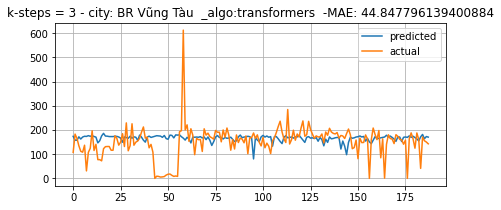

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
BR Vũng Tàu
Epoch:  0/170 - train_loss: 1.7567 - test_loss: 2.881131
Epoch: 42/170 - train_loss: 0.8777 - test_loss: 1.156813
Epoch: 84/170 - train_loss: 0.5314 - test_loss: 0.643182
Epoch: 126/170 - train_loss: 0.3449 - test_loss: 0.415148
Epoch: 168/170 - train_loss: 0.2570 - test_loss: 0.275542
Epoch: 169/170 - train_loss: 0.2492 - test_loss: 0.272936
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 85.6069289043687


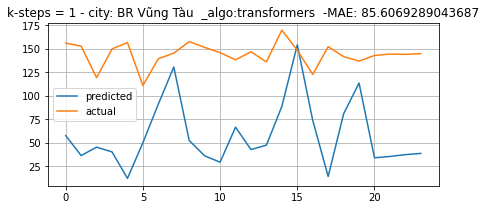

City: BR Vũng Tàu  _algo:transformers  -MAE: 74.9101932557614


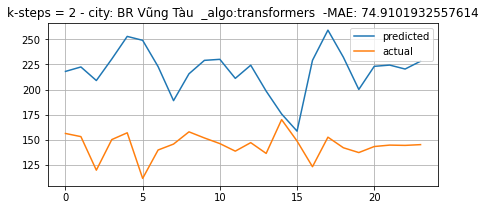

City: BR Vũng Tàu  _algo:transformers  -MAE: 134.15192258067134


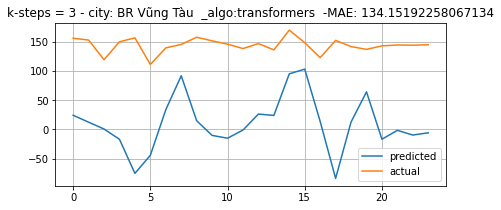

Evaluate on train set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 104.08423140726377


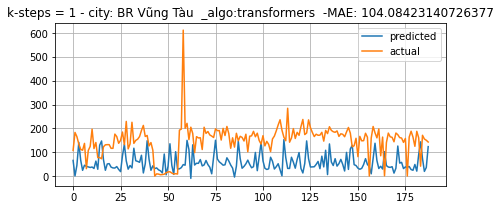

City: BR Vũng Tàu  _algo:transformers  -MAE: 77.26122591833683


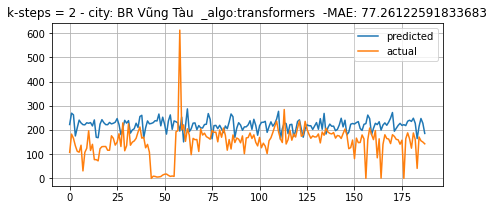

City: BR Vũng Tàu  _algo:transformers  -MAE: 148.54580425303385


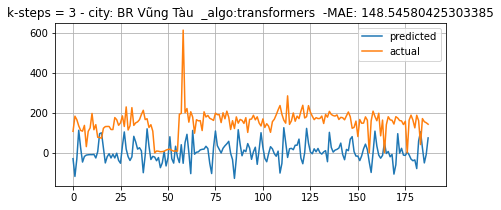

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
BR Vũng Tàu
Epoch:  0/170 - train_loss: 1.1752 - test_loss: 1.164034
Epoch: 42/170 - train_loss: 0.7086 - test_loss: 0.627398
Epoch: 84/170 - train_loss: 0.4562 - test_loss: 0.399131
Epoch: 126/170 - train_loss: 0.3316 - test_loss: 0.278081
Epoch: 168/170 - train_loss: 0.2489 - test_loss: 0.195485
Epoch: 169/170 - train_loss: 0.2559 - test_loss: 0.193381
Evaluate on test set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 18.186241237804456


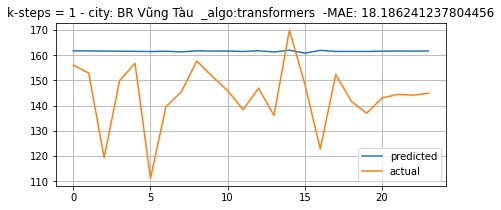

City: BR Vũng Tàu  _algo:transformers  -MAE: 15.616324258850044


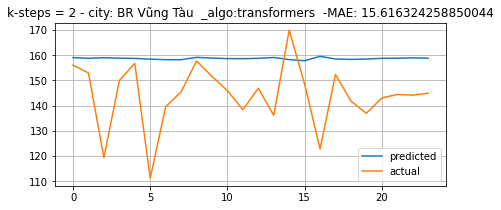

City: BR Vũng Tàu  _algo:transformers  -MAE: 26.94349548999338


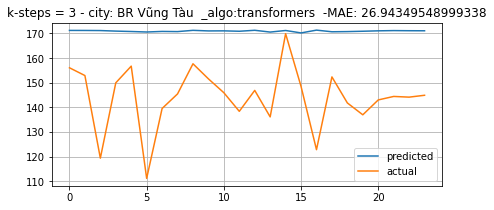

Evaluate on train set: 
City: BR Vũng Tàu  _algo:transformers  -MAE: 40.22177751106172


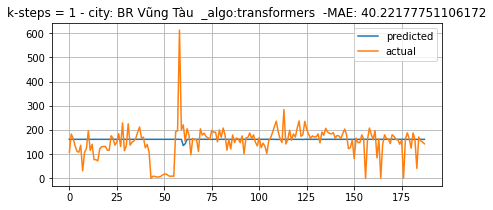

City: BR Vũng Tàu  _algo:transformers  -MAE: 40.41790703680864


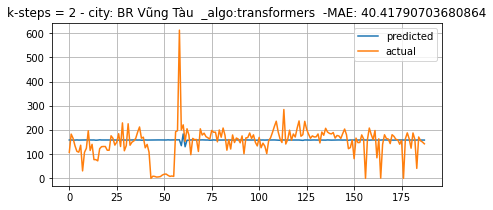

City: BR Vũng Tàu  _algo:transformers  -MAE: 41.56047306967435


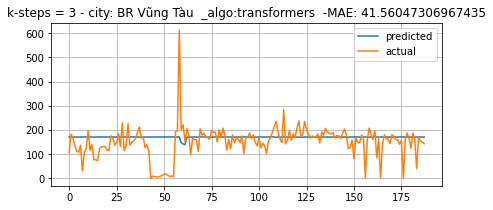

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Min_Average_Temperature
Min_Absolute_Temperature
Diarrhoea_rates
Bình Phước
Epoch:  0/450 - train_loss: 1.2039 - test_loss: 0.827529
Epoch: 112/450 - train_loss: 0.3594 - test_loss: 0.376781
Epoch: 224/450 - train_loss: 0.3522 - test_loss: 0.423862
Epoch: 336/450 - train_loss: 0.3480 - test_loss: 0.427211
Epoch: 448/450 - train_loss: 0.3472 - test_loss: 0.383425
Epoch: 449/450 - train_loss: 0.3524 - test_loss: 0.473555
Evaluate on test set: 
City: Bình Phước  _algo:transformers  -MAE: 23.662503742500558


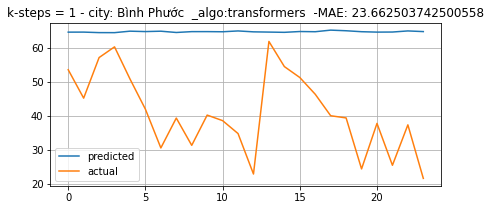

City: Bình Phước  _algo:transformers  -MAE: 23.06263243742265


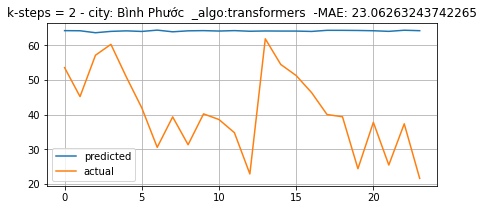

City: Bình Phước  _algo:transformers  -MAE: 20.878775388259218


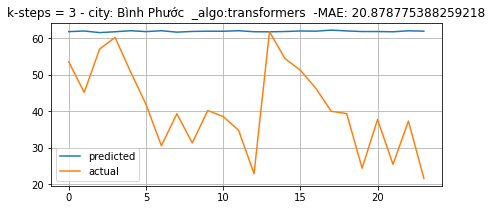

Evaluate on train set: 
City: Bình Phước  _algo:transformers  -MAE: 18.04952212619351


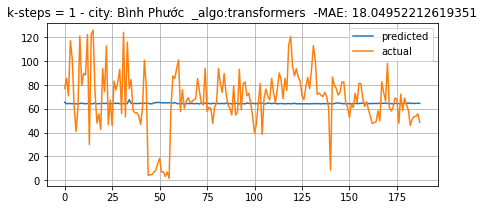

City: Bình Phước  _algo:transformers  -MAE: 18.17037911949555


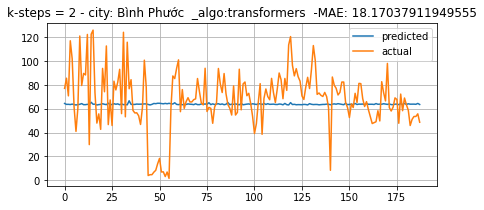

City: Bình Phước  _algo:transformers  -MAE: 18.6521528399656


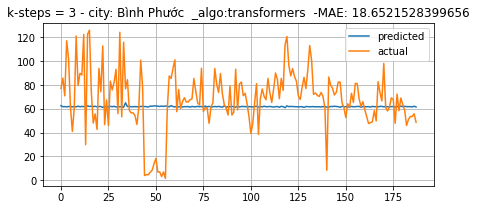

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Min_Absolute_Temperature
Diarrhoea_rates
Bình Phước
Epoch:  0/450 - train_loss: 1.9142 - test_loss: 0.890891
Epoch: 112/450 - train_loss: 0.3562 - test_loss: 0.453017
Epoch: 224/450 - train_loss: 0.3524 - test_loss: 0.457611
Epoch: 336/450 - train_loss: 0.3464 - test_loss: 0.441581
Epoch: 448/450 - train_loss: 0.3523 - test_loss: 0.435374
Epoch: 449/450 - train_loss: 0.3524 - test_loss: 0.425457
Evaluate on test set: 
City: Bình Phước  _algo:transformers  -MAE: 25.385062012475814


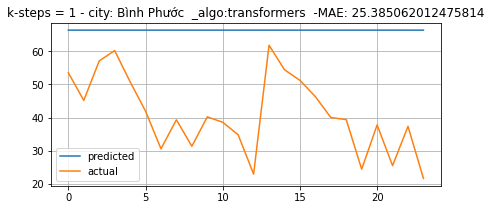

City: Bình Phước  _algo:transformers  -MAE: 23.80646573369199


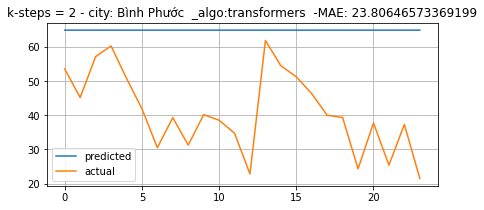

City: Bình Phước  _algo:transformers  -MAE: 24.687301477270655


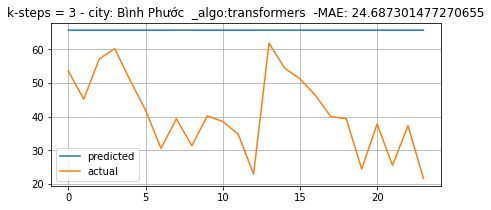

Evaluate on train set: 
City: Bình Phước  _algo:transformers  -MAE: 17.772579033586183


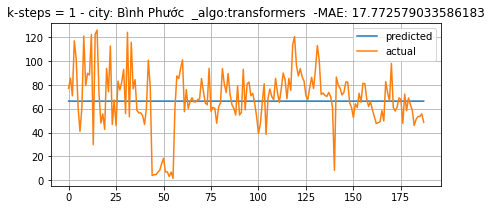

City: Bình Phước  _algo:transformers  -MAE: 17.9696688485897


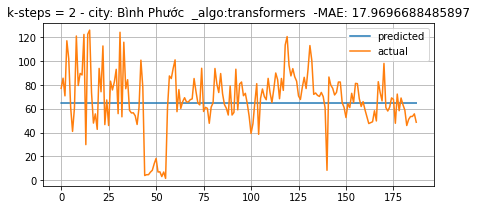

City: Bình Phước  _algo:transformers  -MAE: 17.838103914705258


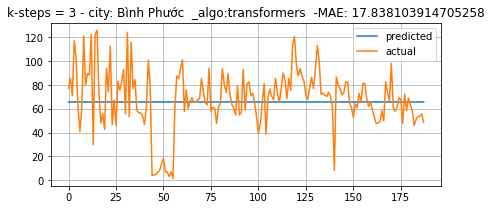

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Min_Absolute_Temperature
Diarrhoea_rates
Bình Phước
Epoch:  0/450 - train_loss: 1.5721 - test_loss: 0.938509
Epoch: 112/450 - train_loss: 0.3552 - test_loss: 0.451662
Epoch: 224/450 - train_loss: 0.3452 - test_loss: 0.429158
Epoch: 336/450 - train_loss: 0.3568 - test_loss: 0.462021
Epoch: 448/450 - train_loss: 0.3531 - test_loss: 0.422225
Epoch: 449/450 - train_loss: 0.3452 - test_loss: 0.404031
Evaluate on test set: 
City: Bình Phước  _algo:transformers  -MAE: 24.415508304130622


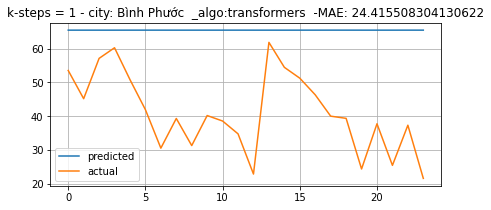

City: Bình Phước  _algo:transformers  -MAE: 24.936890508199838


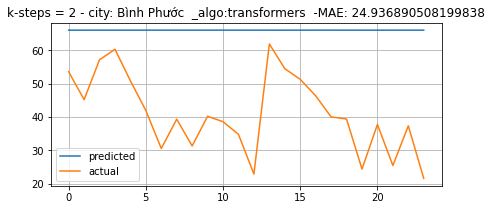

City: Bình Phước  _algo:transformers  -MAE: 24.290151886974556


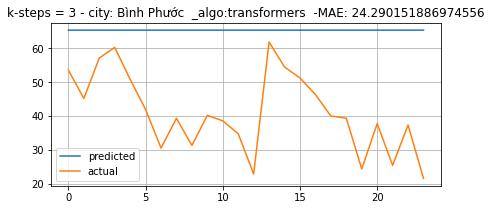

Evaluate on train set: 
City: Bình Phước  _algo:transformers  -MAE: 17.87125040670827


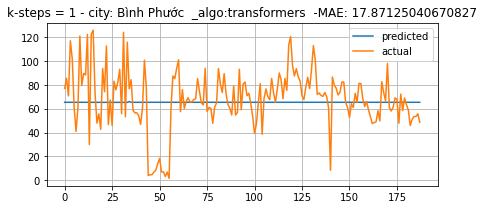

City: Bình Phước  _algo:transformers  -MAE: 17.812603934064875


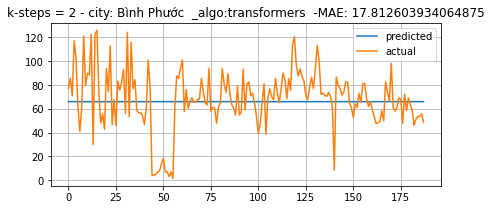

City: Bình Phước  _algo:transformers  -MAE: 17.890029435509913


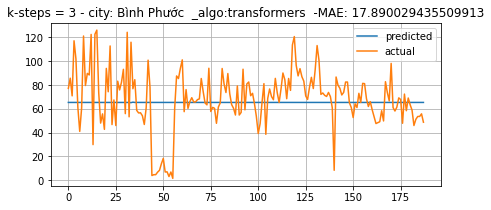

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Min_Absolute_Temperature
Diarrhoea_rates
Bình Phước
Epoch:  0/450 - train_loss: 1.4187 - test_loss: 1.166895
Epoch: 112/450 - train_loss: 0.3448 - test_loss: 0.459370
Epoch: 224/450 - train_loss: 0.3462 - test_loss: 0.412539
Epoch: 336/450 - train_loss: 0.3498 - test_loss: 0.418665
Epoch: 448/450 - train_loss: 0.3479 - test_loss: 0.425375
Epoch: 449/450 - train_loss: 0.3518 - test_loss: 0.440129
Evaluate on test set: 
City: Bình Phước  _algo:transformers  -MAE: 25.300636669815944


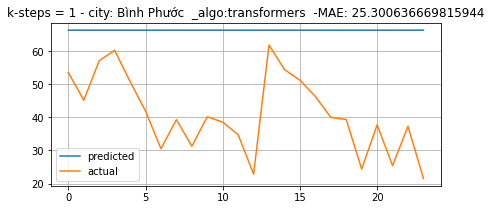

City: Bình Phước  _algo:transformers  -MAE: 24.981579657067403


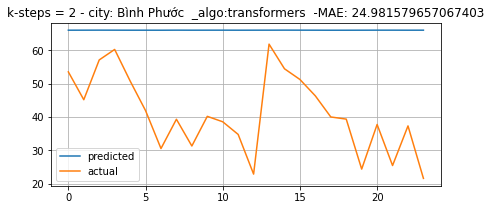

City: Bình Phước  _algo:transformers  -MAE: 25.442418602653515


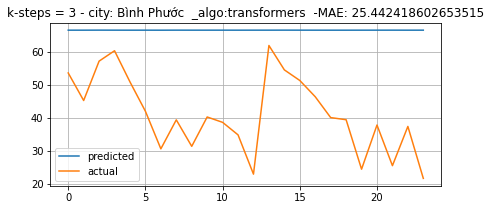

Evaluate on train set: 
City: Bình Phước  _algo:transformers  -MAE: 17.779833762395004


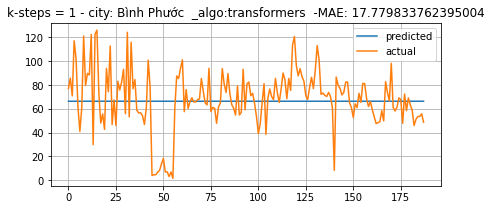

City: Bình Phước  _algo:transformers  -MAE: 17.805984364852698


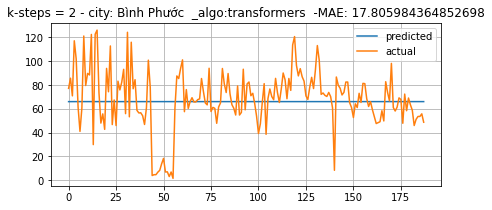

City: Bình Phước  _algo:transformers  -MAE: 17.76709946680645


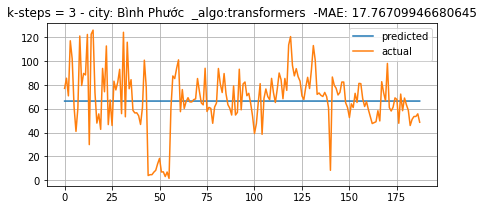

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Min_Absolute_Temperature
Diarrhoea_rates
Bình Phước
Epoch:  0/450 - train_loss: 1.4118 - test_loss: 0.838961
Epoch: 112/450 - train_loss: 0.3470 - test_loss: 0.437873
Epoch: 224/450 - train_loss: 0.3517 - test_loss: 0.439586
Epoch: 336/450 - train_loss: 0.3467 - test_loss: 0.432111
Epoch: 448/450 - train_loss: 0.3452 - test_loss: 0.429451
Epoch: 449/450 - train_loss: 0.3494 - test_loss: 0.429891
Evaluate on test set: 
City: Bình Phước  _algo:transformers  -MAE: 25.704913075194156


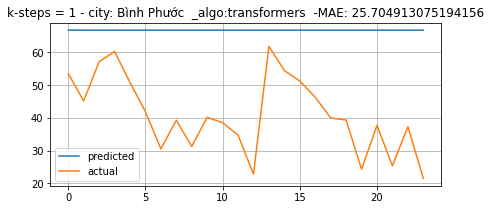

City: Bình Phước  _algo:transformers  -MAE: 24.500567043788163


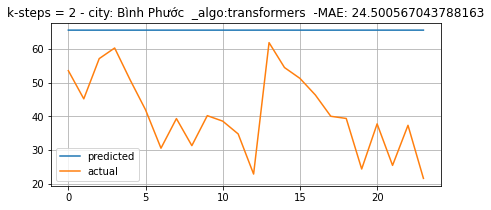

City: Bình Phước  _algo:transformers  -MAE: 23.510823436505063


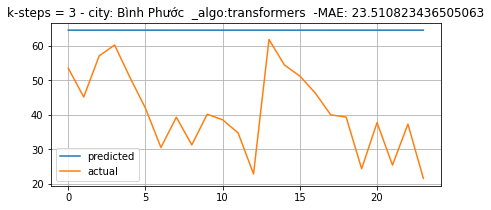

Evaluate on train set: 
City: Bình Phước  _algo:transformers  -MAE: 17.74715541864572


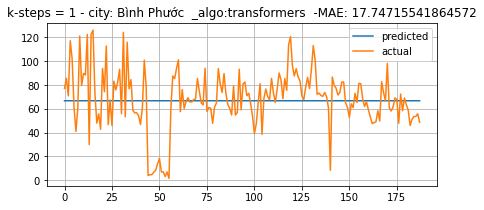

City: Bình Phước  _algo:transformers  -MAE: 17.8630206641989


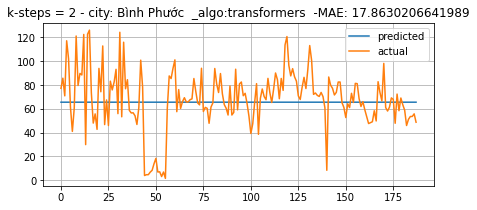

City: Bình Phước  _algo:transformers  -MAE: 18.027605260270978


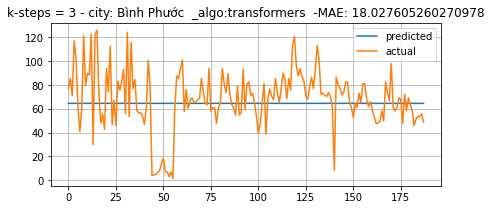

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
n_raining_days
Max_Average_Temperature
Diarrhoea_rates
Bình Thuận
Epoch:  0/240 - train_loss: 1.3087 - test_loss: 0.995796
Epoch: 60/240 - train_loss: 0.3213 - test_loss: 0.274999
Epoch: 120/240 - train_loss: 0.3207 - test_loss: 0.258064
Epoch: 180/240 - train_loss: 0.3234 - test_loss: 0.263004
Epoch: 239/240 - train_loss: 0.3261 - test_loss: 0.267238
Evaluate on test set: 
City: Bình Thuận  _algo:transformers  -MAE: 22.993465225376912


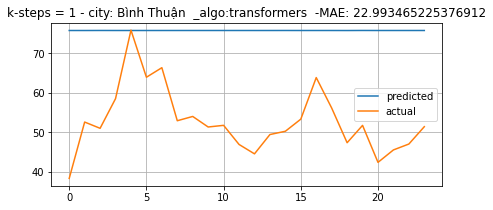

City: Bình Thuận  _algo:transformers  -MAE: 21.990388582736227


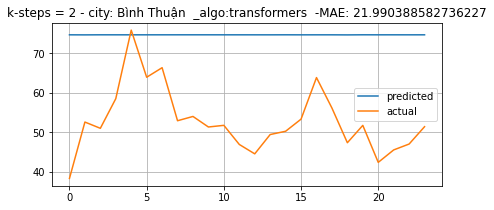

City: Bình Thuận  _algo:transformers  -MAE: 21.501578346505323


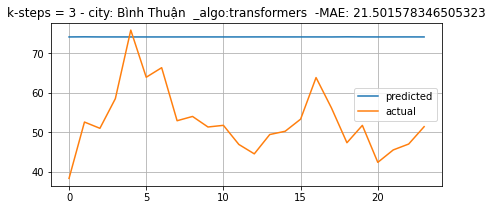

Evaluate on train set: 
City: Bình Thuận  _algo:transformers  -MAE: 24.850500567147463


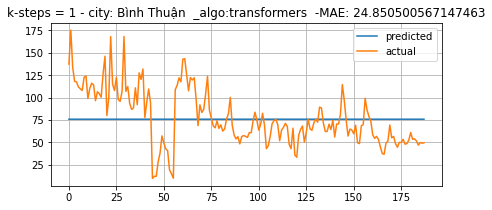

City: Bình Thuận  _algo:transformers  -MAE: 24.67630009743484


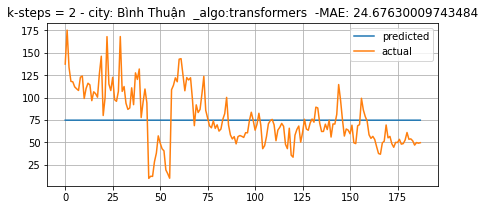

City: Bình Thuận  _algo:transformers  -MAE: 24.60859057124789


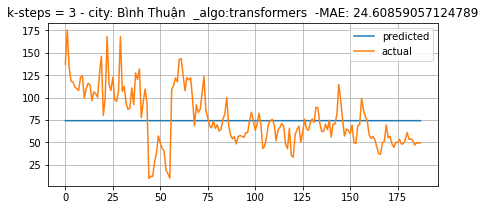

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
n_raining_days
Max_Average_Temperature
Diarrhoea_rates
Bình Thuận
Epoch:  0/240 - train_loss: 1.1539 - test_loss: 0.719498
Epoch: 60/240 - train_loss: 0.3409 - test_loss: 0.266332
Epoch: 120/240 - train_loss: 0.3227 - test_loss: 0.257422
Epoch: 180/240 - train_loss: 0.3199 - test_loss: 0.250766
Epoch: 239/240 - train_loss: 0.3277 - test_loss: 0.255683
Evaluate on test set: 
City: Bình Thuận  _algo:transformers  -MAE: 23.088744544480466


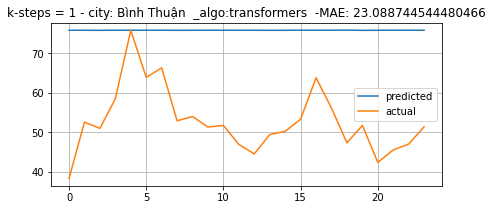

City: Bình Thuận  _algo:transformers  -MAE: 22.537138907663998


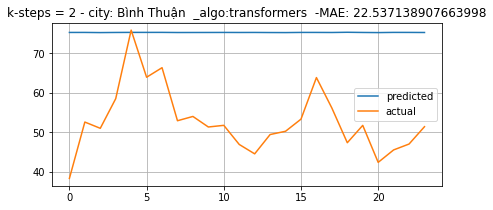

City: Bình Thuận  _algo:transformers  -MAE: 21.06054917503734


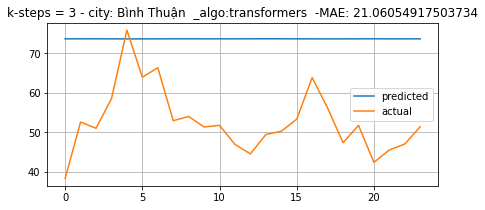

Evaluate on train set: 
City: Bình Thuận  _algo:transformers  -MAE: 24.869868175937476


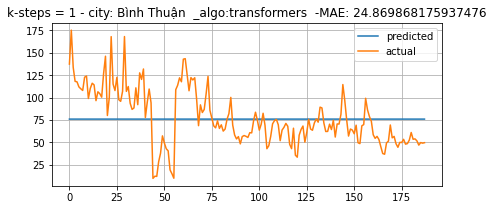

City: Bình Thuận  _algo:transformers  -MAE: 24.765029046681853


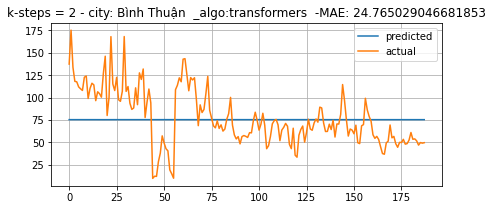

City: Bình Thuận  _algo:transformers  -MAE: 24.55983702181906


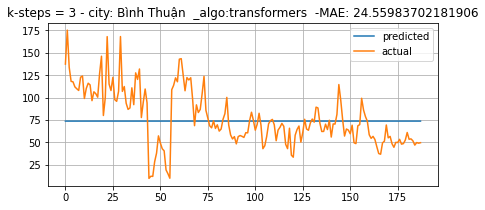

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
n_raining_days
Max_Average_Temperature
Diarrhoea_rates
Bình Thuận
Epoch:  0/240 - train_loss: 1.2608 - test_loss: 0.831326
Epoch: 60/240 - train_loss: 0.3246 - test_loss: 0.266840
Epoch: 120/240 - train_loss: 0.3246 - test_loss: 0.264634
Epoch: 180/240 - train_loss: 0.3241 - test_loss: 0.260372
Epoch: 239/240 - train_loss: 0.3238 - test_loss: 0.261311
Evaluate on test set: 
City: Bình Thuận  _algo:transformers  -MAE: 24.02713176061447


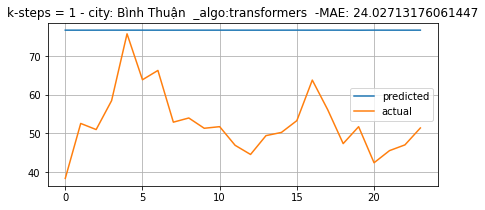

City: Bình Thuận  _algo:transformers  -MAE: 22.242504890089993


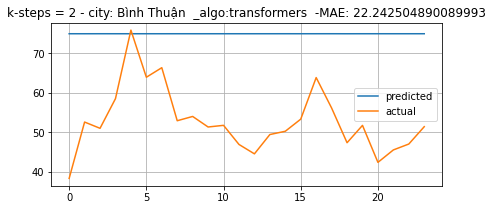

City: Bình Thuận  _algo:transformers  -MAE: 22.18170841717274


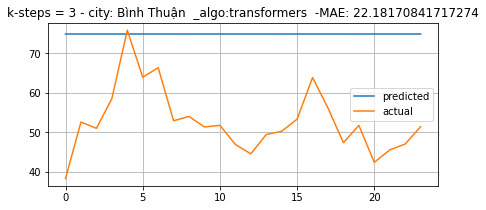

Evaluate on train set: 
City: Bình Thuận  _algo:transformers  -MAE: 25.059195575449568


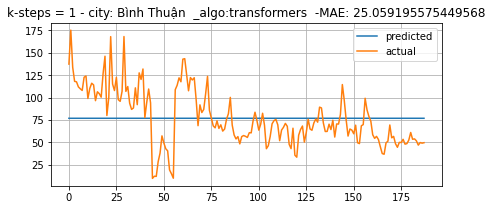

City: Bình Thuận  _algo:transformers  -MAE: 24.719063123853832


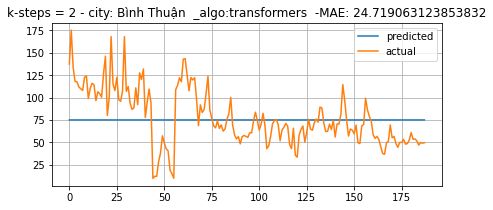

City: Bình Thuận  _algo:transformers  -MAE: 24.708997922445217


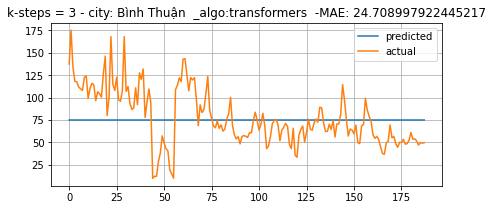

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
n_raining_days
Max_Average_Temperature
Diarrhoea_rates
Bình Thuận
Epoch:  0/240 - train_loss: 1.2453 - test_loss: 1.136742
Epoch: 60/240 - train_loss: 0.3292 - test_loss: 0.280964
Epoch: 120/240 - train_loss: 0.3209 - test_loss: 0.286957
Epoch: 180/240 - train_loss: 0.3229 - test_loss: 0.254335
Epoch: 239/240 - train_loss: 0.3249 - test_loss: 0.259384
Evaluate on test set: 
City: Bình Thuận  _algo:transformers  -MAE: 23.43028767062602


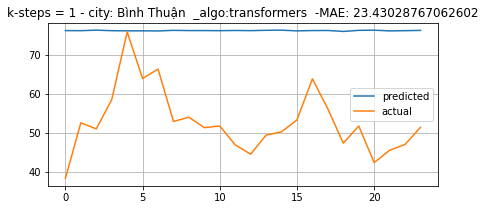

City: Bình Thuận  _algo:transformers  -MAE: 22.88543292409082


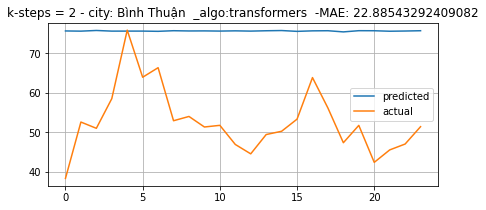

City: Bình Thuận  _algo:transformers  -MAE: 22.083931643262968


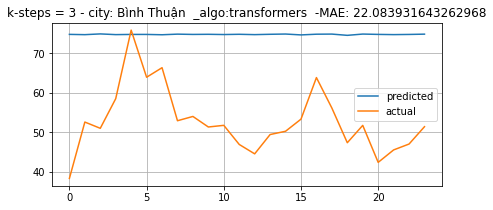

Evaluate on train set: 
City: Bình Thuận  _algo:transformers  -MAE: 24.961365977194635


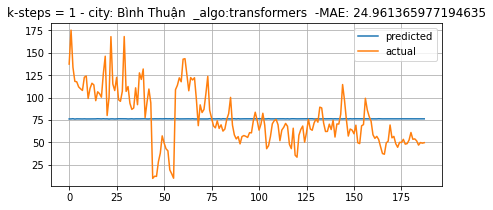

City: Bình Thuận  _algo:transformers  -MAE: 24.843908583088368


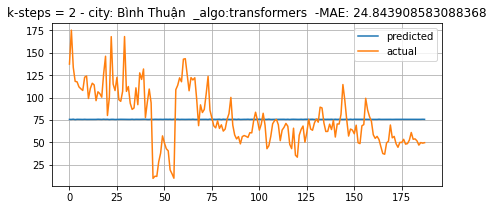

City: Bình Thuận  _algo:transformers  -MAE: 24.69513469952183


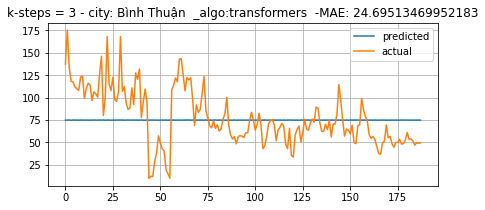

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
n_raining_days
Max_Average_Temperature
Diarrhoea_rates
Bình Thuận
Epoch:  0/240 - train_loss: 1.4387 - test_loss: 0.813816
Epoch: 60/240 - train_loss: 0.3261 - test_loss: 0.258650
Epoch: 120/240 - train_loss: 0.3224 - test_loss: 0.282196
Epoch: 180/240 - train_loss: 0.3226 - test_loss: 0.257974
Epoch: 239/240 - train_loss: 0.3238 - test_loss: 0.276654
Evaluate on test set: 
City: Bình Thuận  _algo:transformers  -MAE: 22.48755153208582


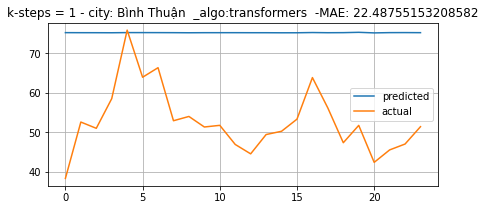

City: Bình Thuận  _algo:transformers  -MAE: 22.901588677131254


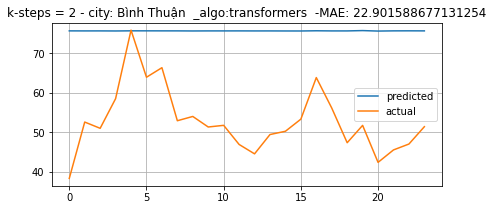

City: Bình Thuận  _algo:transformers  -MAE: 21.334725282524463


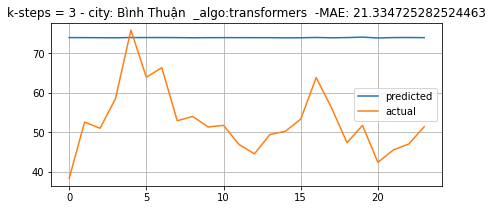

Evaluate on train set: 
City: Bình Thuận  _algo:transformers  -MAE: 24.757060254516073


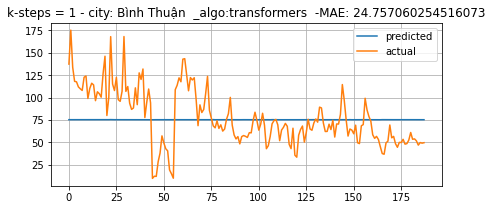

City: Bình Thuận  _algo:transformers  -MAE: 24.83058998110101


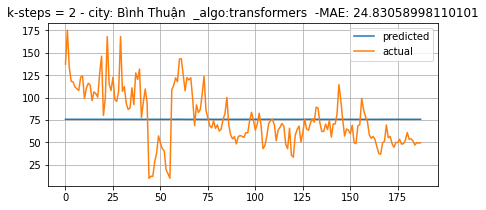

City: Bình Thuận  _algo:transformers  -MAE: 24.583577528949842


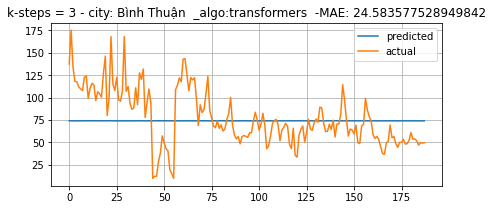

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
Bình Định
Epoch:  0/330 - train_loss: 0.7613 - test_loss: 0.609083
Epoch: 82/330 - train_loss: 0.1591 - test_loss: 0.112855
Epoch: 164/330 - train_loss: 0.1616 - test_loss: 0.125191
Epoch: 246/330 - train_loss: 0.1532 - test_loss: 0.123391
Epoch: 328/330 - train_loss: 0.1516 - test_loss: 0.120384
Epoch: 329/330 - train_loss: 0.1544 - test_loss: 0.130957
Evaluate on test set: 
City: Bình Định  _algo:transformers  -MAE: 4.526712663789098


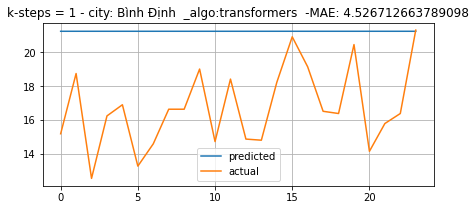

City: Bình Định  _algo:transformers  -MAE: 5.111734625195466


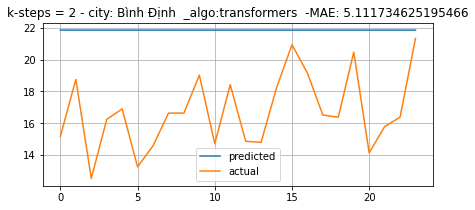

City: Bình Định  _algo:transformers  -MAE: 6.833949668644124


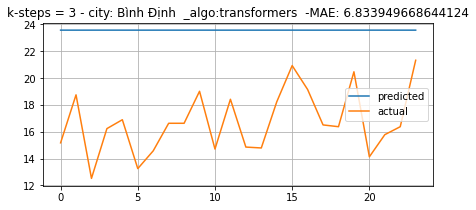

Evaluate on train set: 
City: Bình Định  _algo:transformers  -MAE: 15.558673817111245


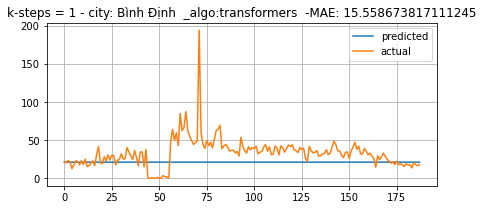

City: Bình Định  _algo:transformers  -MAE: 15.232890670133457


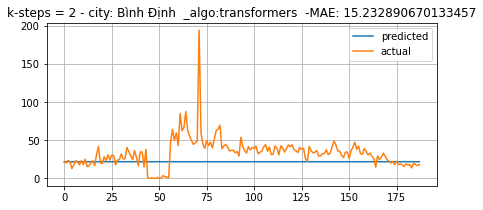

City: Bình Định  _algo:transformers  -MAE: 14.393294203515504


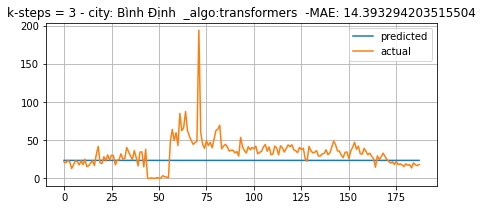

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
Bình Định
Epoch:  0/330 - train_loss: 0.7251 - test_loss: 0.557197
Epoch: 82/330 - train_loss: 0.1528 - test_loss: 0.153262
Epoch: 164/330 - train_loss: 0.1541 - test_loss: 0.132319
Epoch: 246/330 - train_loss: 0.1543 - test_loss: 0.127866
Epoch: 328/330 - train_loss: 0.1561 - test_loss: 0.150813
Epoch: 329/330 - train_loss: 0.1535 - test_loss: 0.120671
Evaluate on test set: 
City: Bình Định  _algo:transformers  -MAE: 10.246693031302591


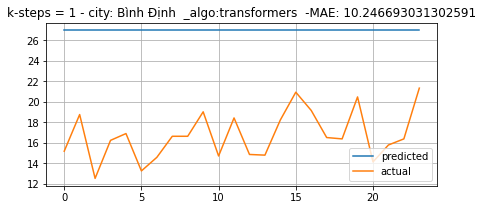

City: Bình Định  _algo:transformers  -MAE: 12.09387383239853


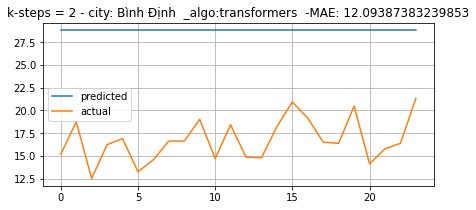

City: Bình Định  _algo:transformers  -MAE: 10.845031796619105


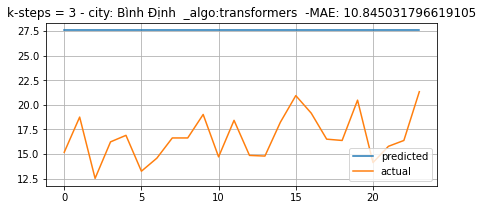

Evaluate on train set: 
City: Bình Định  _algo:transformers  -MAE: 13.149097868166416


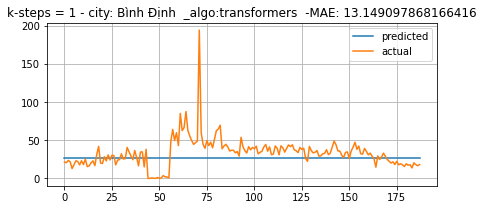

City: Bình Định  _algo:transformers  -MAE: 12.625215041370641


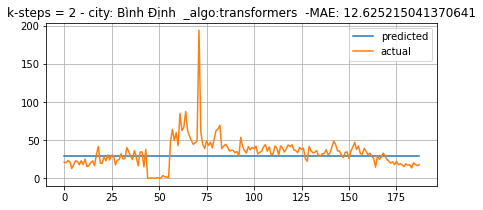

City: Bình Định  _algo:transformers  -MAE: 12.971456270595413


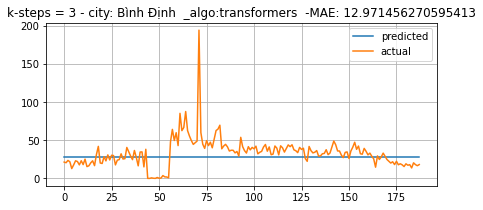

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
Bình Định
Epoch:  0/330 - train_loss: 0.7622 - test_loss: 0.573182
Epoch: 82/330 - train_loss: 0.1573 - test_loss: 0.122699
Epoch: 164/330 - train_loss: 0.1605 - test_loss: 0.127376
Epoch: 246/330 - train_loss: 0.1540 - test_loss: 0.135911
Epoch: 328/330 - train_loss: 0.1519 - test_loss: 0.133531
Epoch: 329/330 - train_loss: 0.1519 - test_loss: 0.134639
Evaluate on test set: 
City: Bình Định  _algo:transformers  -MAE: 10.810664388428213


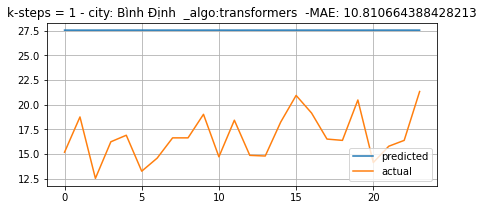

City: Bình Định  _algo:transformers  -MAE: 9.584585211850783


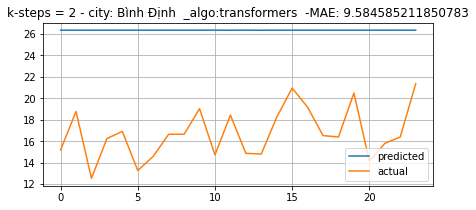

City: Bình Định  _algo:transformers  -MAE: 7.2500446088037185


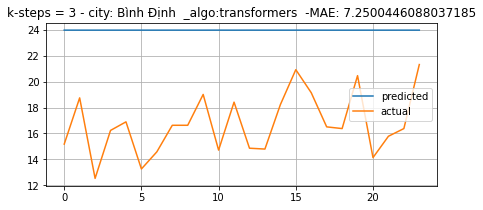

Evaluate on train set: 
City: Bình Định  _algo:transformers  -MAE: 12.981284031570548


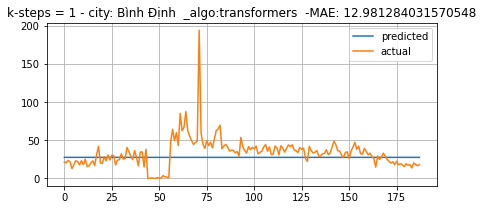

City: Bình Định  _algo:transformers  -MAE: 13.353316017877829


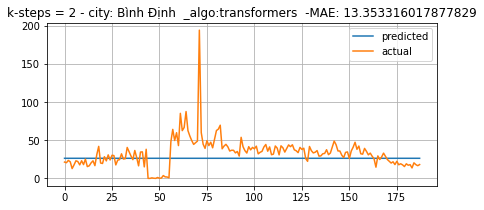

City: Bình Định  _algo:transformers  -MAE: 14.21285913270605


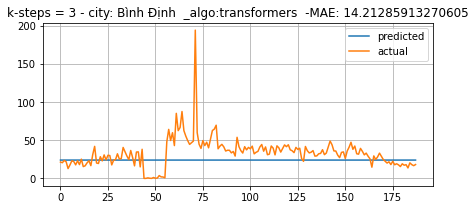

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
Bình Định
Epoch:  0/330 - train_loss: 0.7601 - test_loss: 0.568716
Epoch: 82/330 - train_loss: 0.1537 - test_loss: 0.123287
Epoch: 164/330 - train_loss: 0.1519 - test_loss: 0.130607
Epoch: 246/330 - train_loss: 0.1527 - test_loss: 0.128679
Epoch: 328/330 - train_loss: 0.1601 - test_loss: 0.137645
Epoch: 329/330 - train_loss: 0.1529 - test_loss: 0.128191
Evaluate on test set: 
City: Bình Định  _algo:transformers  -MAE: 12.26616019613859


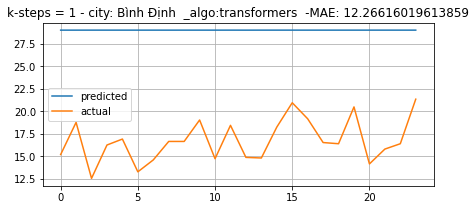

City: Bình Định  _algo:transformers  -MAE: 7.428586523663107


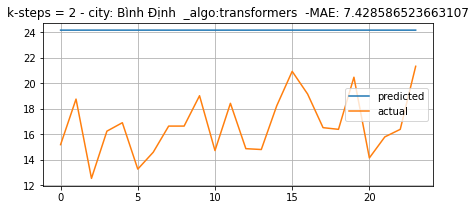

City: Bình Định  _algo:transformers  -MAE: 8.305529466614294


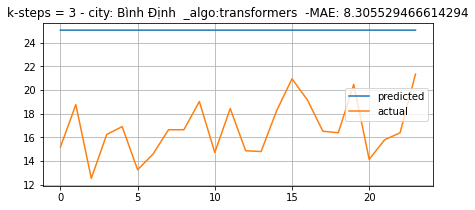

Evaluate on train set: 
City: Bình Định  _algo:transformers  -MAE: 12.579036460537022


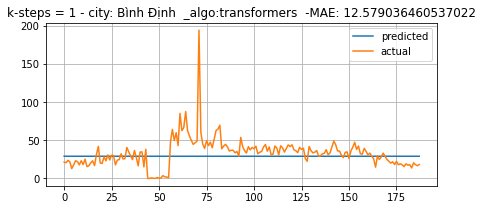

City: Bình Định  _algo:transformers  -MAE: 14.13673808049879


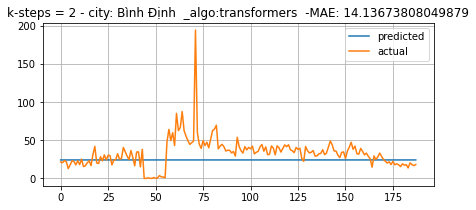

City: Bình Định  _algo:transformers  -MAE: 13.789557892464105


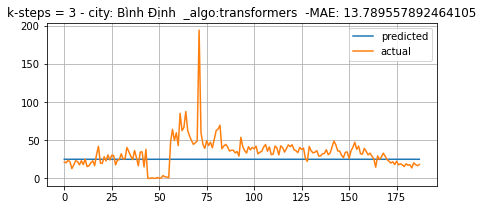

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Absolute_Temperature
Diarrhoea_rates
Bình Định
Epoch:  0/330 - train_loss: 0.7436 - test_loss: 0.555386
Epoch: 82/330 - train_loss: 0.1540 - test_loss: 0.118760
Epoch: 164/330 - train_loss: 0.1591 - test_loss: 0.122237
Epoch: 246/330 - train_loss: 0.1531 - test_loss: 0.145293
Epoch: 328/330 - train_loss: 0.1554 - test_loss: 0.137836
Epoch: 329/330 - train_loss: 0.1535 - test_loss: 0.126167
Evaluate on test set: 
City: Bình Định  _algo:transformers  -MAE: 5.426234089576688


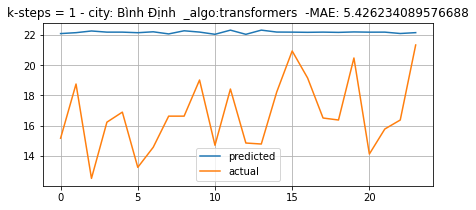

City: Bình Định  _algo:transformers  -MAE: 7.924587724849857


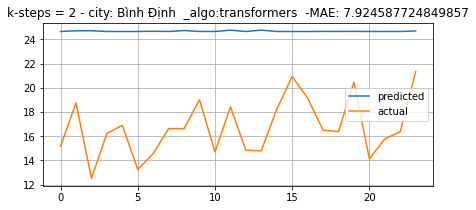

City: Bình Định  _algo:transformers  -MAE: 9.495041974094024


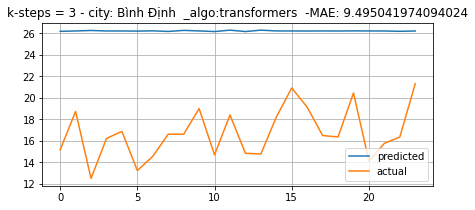

Evaluate on train set: 
City: Bình Định  _algo:transformers  -MAE: 15.06587020235774


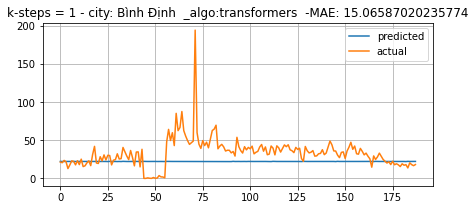

City: Bình Định  _algo:transformers  -MAE: 13.936151169561096


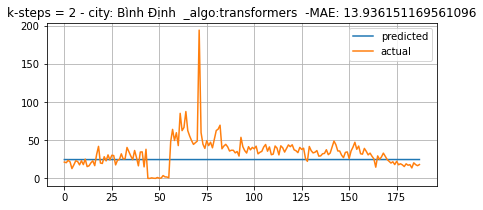

City: Bình Định  _algo:transformers  -MAE: 13.382175768953601


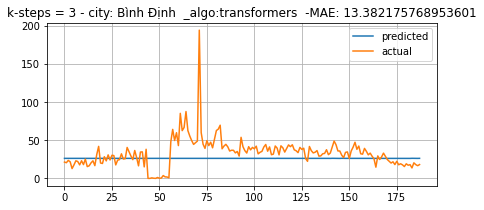

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/380 - train_loss: 0.7807 - test_loss: 0.605250
Epoch: 95/380 - train_loss: 0.1854 - test_loss: 0.117944
Epoch: 190/380 - train_loss: 0.1838 - test_loss: 0.116764
Epoch: 285/380 - train_loss: 0.1840 - test_loss: 0.115903
Epoch: 379/380 - train_loss: 0.1834 - test_loss: 0.119252
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 9.459397560338488


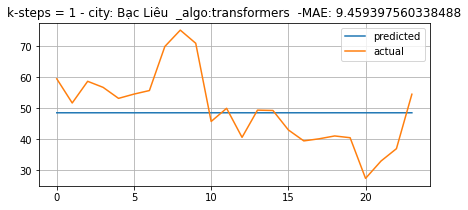

City: Bạc Liêu  _algo:transformers  -MAE: 9.327341041564637


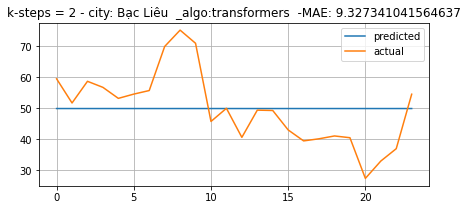

City: Bạc Liêu  _algo:transformers  -MAE: 9.690511047104097


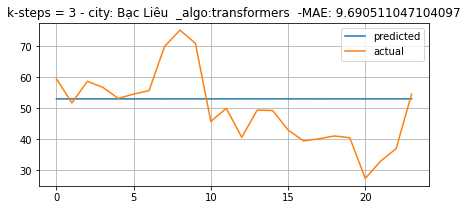

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 21.15920384078497


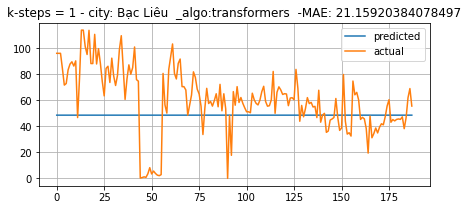

City: Bạc Liêu  _algo:transformers  -MAE: 20.6354501164298


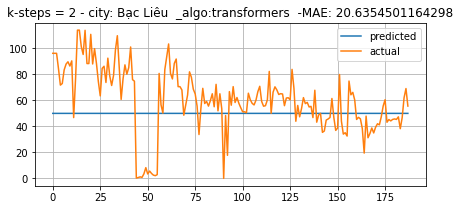

City: Bạc Liêu  _algo:transformers  -MAE: 19.62084737913975


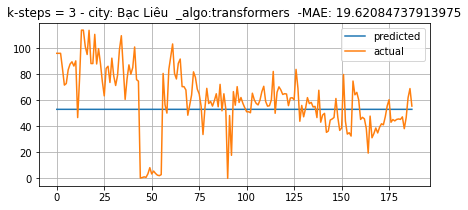

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/380 - train_loss: 0.9642 - test_loss: 0.719890
Epoch: 95/380 - train_loss: 0.1854 - test_loss: 0.134494
Epoch: 190/380 - train_loss: 0.1828 - test_loss: 0.117057
Epoch: 285/380 - train_loss: 0.1849 - test_loss: 0.118979
Epoch: 379/380 - train_loss: 0.1821 - test_loss: 0.123478
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 9.549786727751291


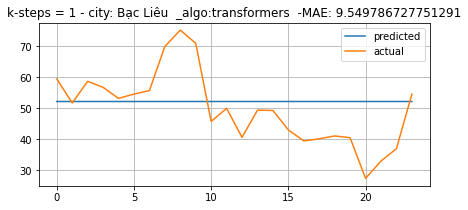

City: Bạc Liêu  _algo:transformers  -MAE: 9.363336116973558


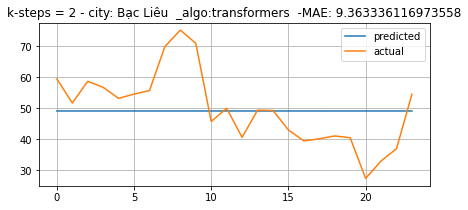

City: Bạc Liêu  _algo:transformers  -MAE: 9.435329840420911


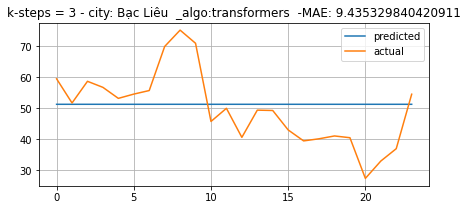

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 19.881601583784267


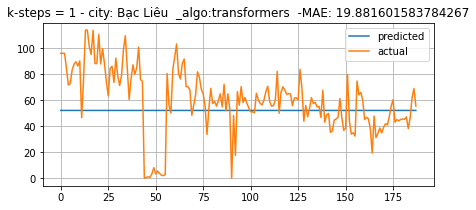

City: Bạc Liêu  _algo:transformers  -MAE: 20.937348263956615


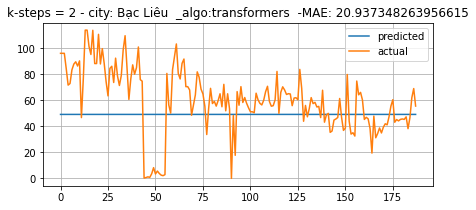

City: Bạc Liêu  _algo:transformers  -MAE: 20.164928756710584


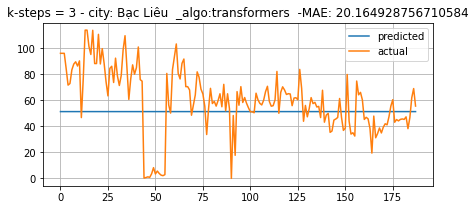

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/380 - train_loss: 0.9713 - test_loss: 0.622798
Epoch: 95/380 - train_loss: 0.1839 - test_loss: 0.117323
Epoch: 190/380 - train_loss: 0.1850 - test_loss: 0.125880
Epoch: 285/380 - train_loss: 0.1849 - test_loss: 0.124649
Epoch: 379/380 - train_loss: 0.1821 - test_loss: 0.128061
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 9.64610117944608


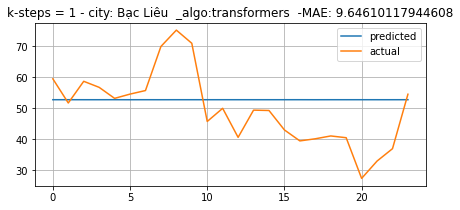

City: Bạc Liêu  _algo:transformers  -MAE: 9.61928921950751


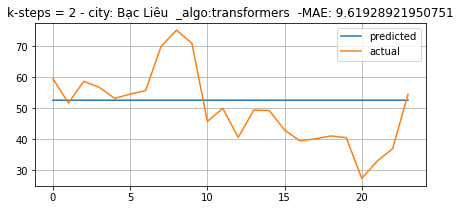

City: Bạc Liêu  _algo:transformers  -MAE: 9.464229490143483


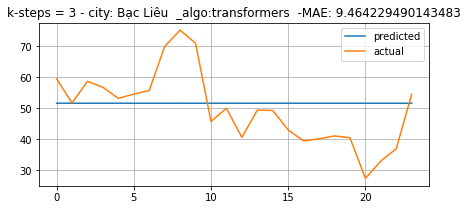

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 19.70311170733485


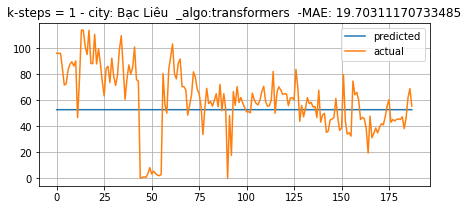

City: Bạc Liêu  _algo:transformers  -MAE: 19.752967666397737


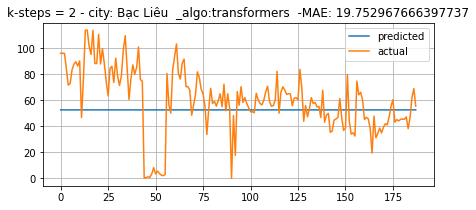

City: Bạc Liêu  _algo:transformers  -MAE: 20.0551733777568


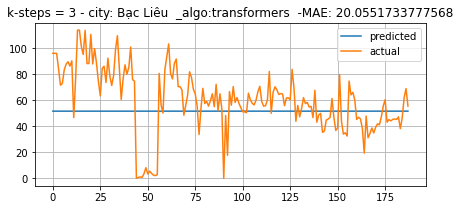

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/380 - train_loss: 1.1905 - test_loss: 0.743495
Epoch: 95/380 - train_loss: 0.1826 - test_loss: 0.132802
Epoch: 190/380 - train_loss: 0.1847 - test_loss: 0.111534
Epoch: 285/380 - train_loss: 0.1848 - test_loss: 0.113043
Epoch: 379/380 - train_loss: 0.1859 - test_loss: 0.121492
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 9.635185662185256


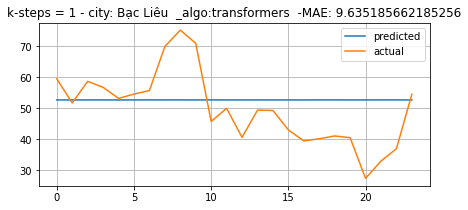

City: Bạc Liêu  _algo:transformers  -MAE: 9.688673556065021


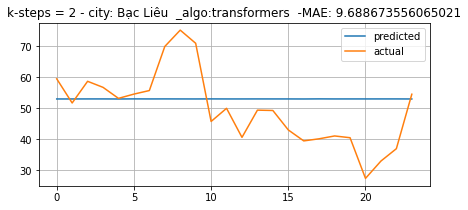

City: Bạc Liêu  _algo:transformers  -MAE: 9.663870336758519


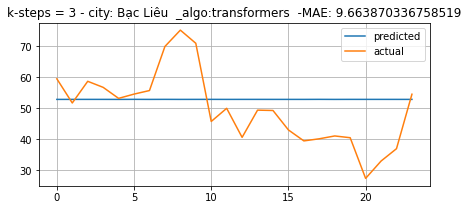

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 19.71934757632009


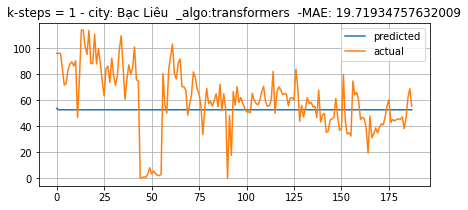

City: Bạc Liêu  _algo:transformers  -MAE: 19.594219858167143


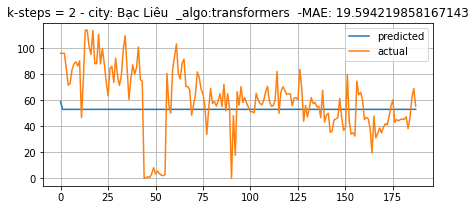

City: Bạc Liêu  _algo:transformers  -MAE: 19.6716670119168


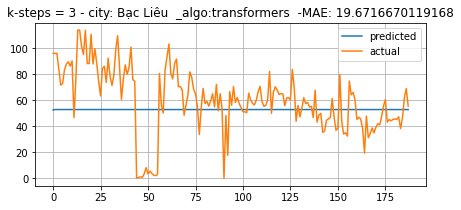

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/380 - train_loss: 1.0547 - test_loss: 0.688631
Epoch: 95/380 - train_loss: 0.1869 - test_loss: 0.105244
Epoch: 190/380 - train_loss: 0.1854 - test_loss: 0.115185
Epoch: 285/380 - train_loss: 0.1836 - test_loss: 0.125385
Epoch: 379/380 - train_loss: 0.1846 - test_loss: 0.120232
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 9.569419732353314


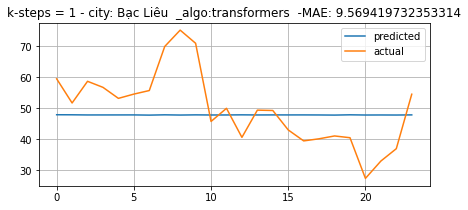

City: Bạc Liêu  _algo:transformers  -MAE: 10.261997918903122


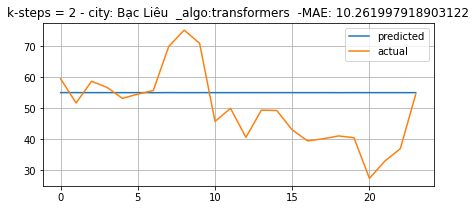

City: Bạc Liêu  _algo:transformers  -MAE: 9.39624132748071


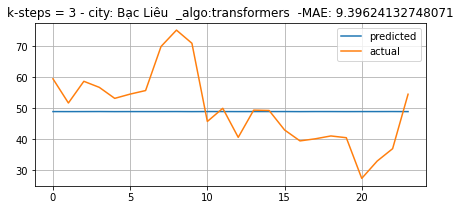

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 21.443023108043946


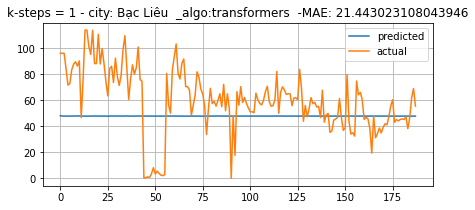

City: Bạc Liêu  _algo:transformers  -MAE: 19.05804920983278


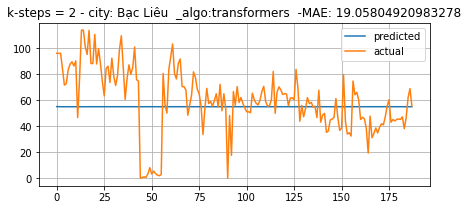

City: Bạc Liêu  _algo:transformers  -MAE: 21.012720462692357


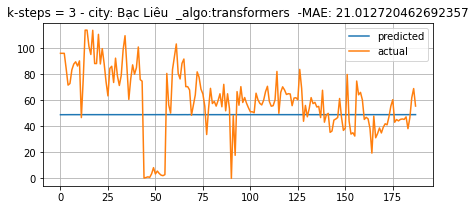

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Total_Rainfall
Min_Average_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/250 - train_loss: 0.7631 - test_loss: 0.560951
Epoch: 62/250 - train_loss: 0.1442 - test_loss: 0.064063
Epoch: 124/250 - train_loss: 0.1520 - test_loss: 0.062748
Epoch: 186/250 - train_loss: 0.1429 - test_loss: 0.063477
Epoch: 248/250 - train_loss: 0.1429 - test_loss: 0.063800
Epoch: 249/250 - train_loss: 0.1435 - test_loss: 0.066970
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 14.226997200408464


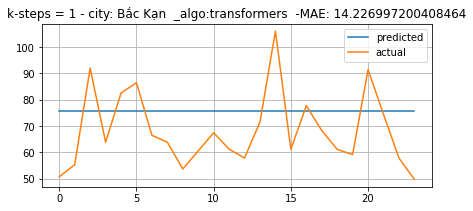

City: Bắc Kạn  _algo:transformers  -MAE: 13.04875055147592


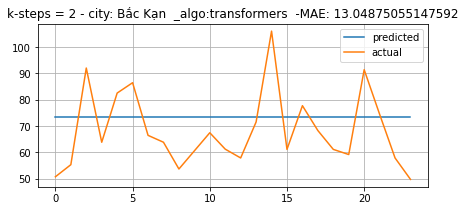

City: Bắc Kạn  _algo:transformers  -MAE: 12.96026296095598


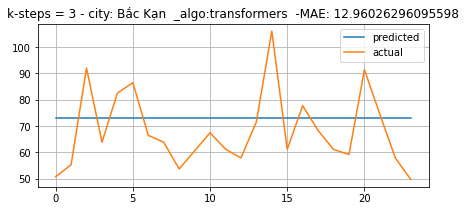

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 32.56240292590282


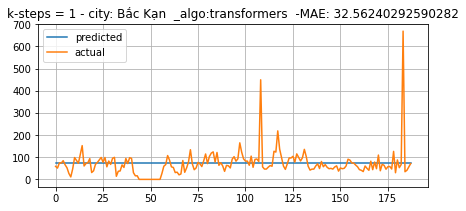

City: Bắc Kạn  _algo:transformers  -MAE: 31.932383707702492


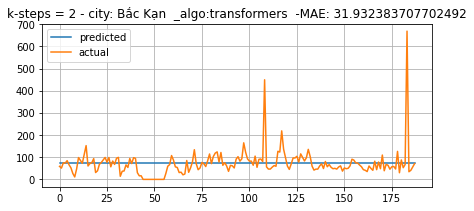

City: Bắc Kạn  _algo:transformers  -MAE: 31.887198554492244


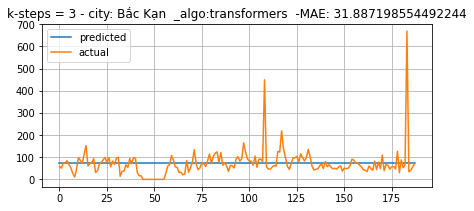

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Min_Average_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/250 - train_loss: 0.9874 - test_loss: 0.621621
Epoch: 62/250 - train_loss: 0.1455 - test_loss: 0.064027
Epoch: 124/250 - train_loss: 0.1422 - test_loss: 0.064956
Epoch: 186/250 - train_loss: 0.1434 - test_loss: 0.068473
Epoch: 248/250 - train_loss: 0.1508 - test_loss: 0.063014
Epoch: 249/250 - train_loss: 0.1431 - test_loss: 0.063249
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 10.98178657567739


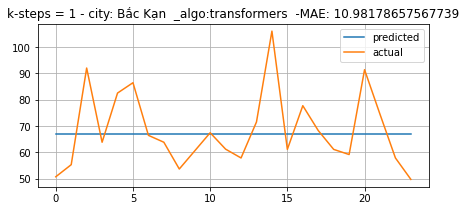

City: Bắc Kạn  _algo:transformers  -MAE: 12.300486861854637


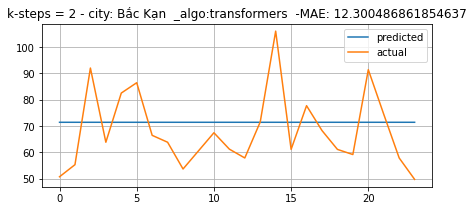

City: Bắc Kạn  _algo:transformers  -MAE: 10.787607619475088


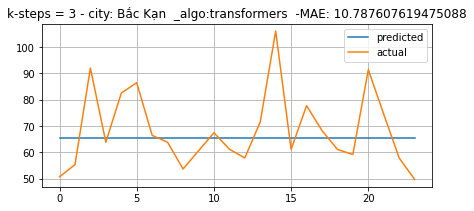

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 31.01412901073118


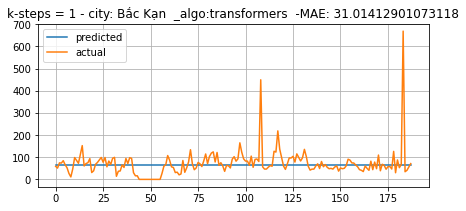

City: Bắc Kạn  _algo:transformers  -MAE: 31.560105067645267


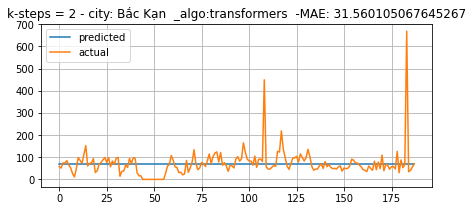

City: Bắc Kạn  _algo:transformers  -MAE: 30.922447854327103


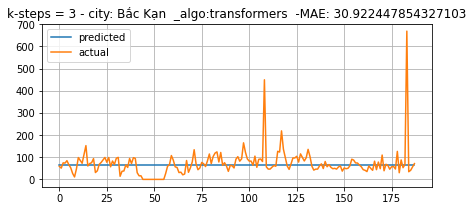

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Min_Average_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/250 - train_loss: 0.7484 - test_loss: 0.550896
Epoch: 62/250 - train_loss: 0.1432 - test_loss: 0.064255
Epoch: 124/250 - train_loss: 0.1434 - test_loss: 0.064039
Epoch: 186/250 - train_loss: 0.1435 - test_loss: 0.067212
Epoch: 248/250 - train_loss: 0.1429 - test_loss: 0.065547
Epoch: 249/250 - train_loss: 0.1432 - test_loss: 0.062931
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 11.010979986312007


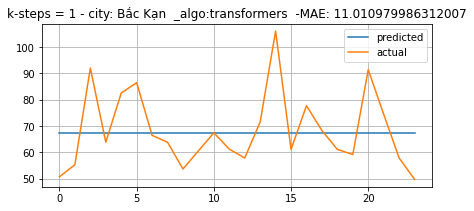

City: Bắc Kạn  _algo:transformers  -MAE: 10.998702992066997


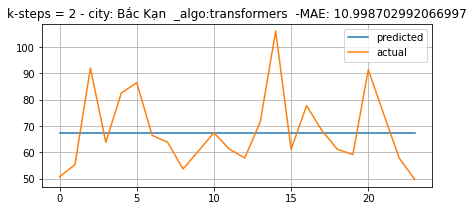

City: Bắc Kạn  _algo:transformers  -MAE: 13.685833156572665


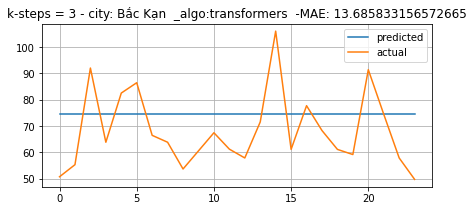

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 31.029036229121193


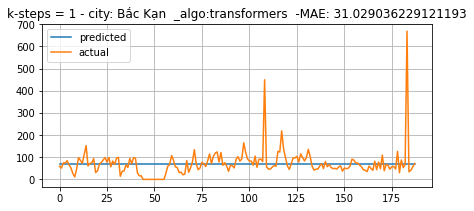

City: Bắc Kạn  _algo:transformers  -MAE: 31.022767571036344


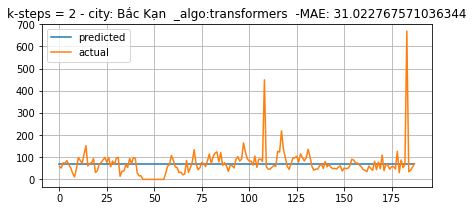

City: Bắc Kạn  _algo:transformers  -MAE: 32.27530533395847


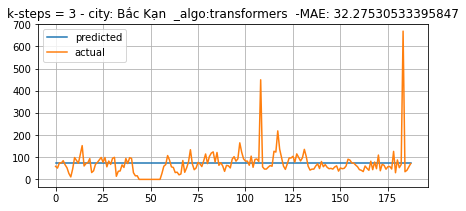

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Min_Average_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/250 - train_loss: 1.0106 - test_loss: 0.646005
Epoch: 62/250 - train_loss: 0.1462 - test_loss: 0.067274
Epoch: 124/250 - train_loss: 0.1442 - test_loss: 0.063455
Epoch: 186/250 - train_loss: 0.1424 - test_loss: 0.066783
Epoch: 248/250 - train_loss: 0.1443 - test_loss: 0.064788
Epoch: 249/250 - train_loss: 0.1433 - test_loss: 0.061587
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 12.279743761590849


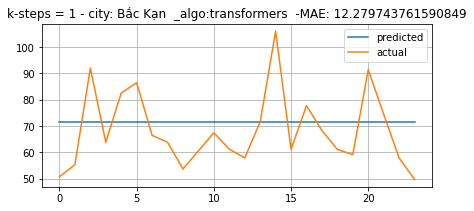

City: Bắc Kạn  _algo:transformers  -MAE: 13.099774859988472


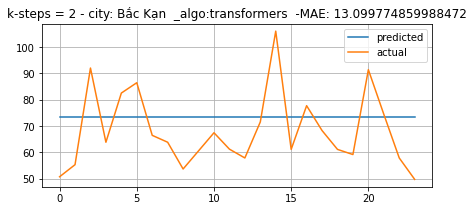

City: Bắc Kạn  _algo:transformers  -MAE: 10.777295102149088


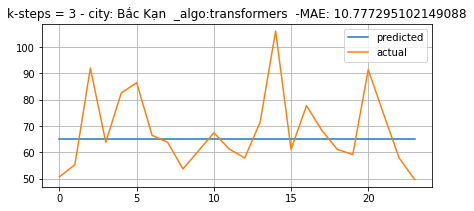

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 31.54885081014052


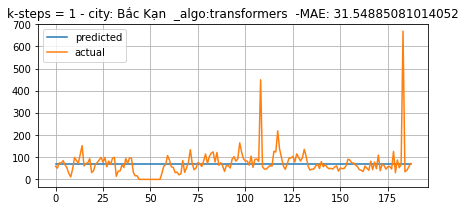

City: Bắc Kạn  _algo:transformers  -MAE: 31.958437550436564


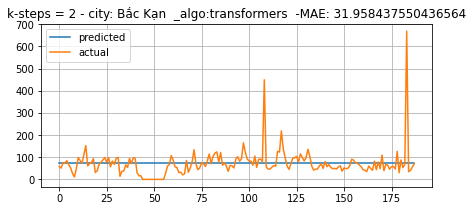

City: Bắc Kạn  _algo:transformers  -MAE: 30.9182845698313


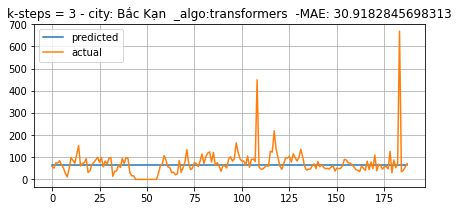

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Min_Average_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/250 - train_loss: 0.7319 - test_loss: 0.544219
Epoch: 62/250 - train_loss: 0.1519 - test_loss: 0.064475
Epoch: 124/250 - train_loss: 0.1429 - test_loss: 0.069265
Epoch: 186/250 - train_loss: 0.1423 - test_loss: 0.063212
Epoch: 248/250 - train_loss: 0.1434 - test_loss: 0.059755
Epoch: 249/250 - train_loss: 0.1422 - test_loss: 0.063943
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 13.000746161445127


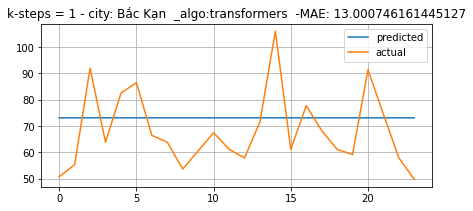

City: Bắc Kạn  _algo:transformers  -MAE: 11.89351597994933


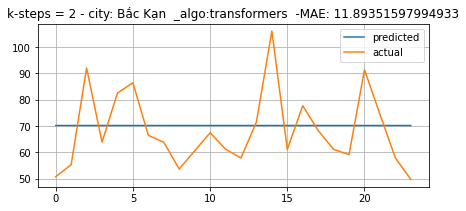

City: Bắc Kạn  _algo:transformers  -MAE: 11.589669508317266


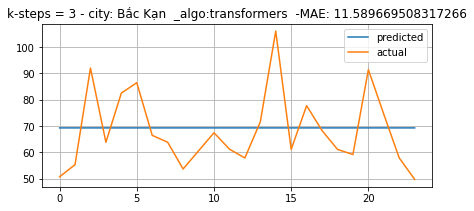

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 31.907871552838426


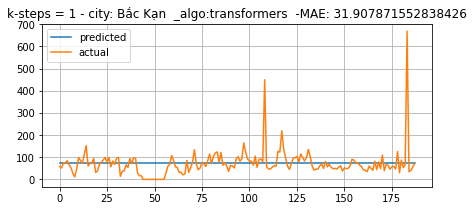

City: Bắc Kạn  _algo:transformers  -MAE: 31.36191911758021


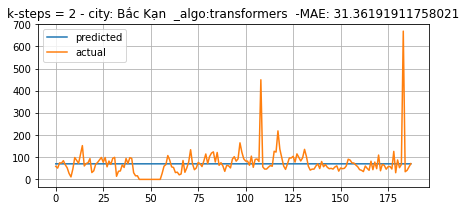

City: Bắc Kạn  _algo:transformers  -MAE: 31.247012838230326


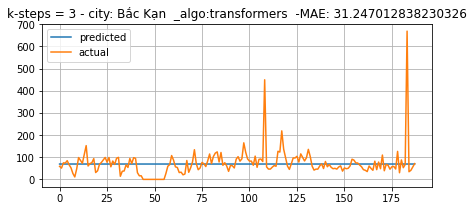

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/300 - train_loss: 0.8953 - test_loss: 0.611169
Epoch: 75/300 - train_loss: 0.3010 - test_loss: 0.433551
Epoch: 150/300 - train_loss: 0.2971 - test_loss: 0.439587
Epoch: 225/300 - train_loss: 0.2990 - test_loss: 0.440222
Epoch: 299/300 - train_loss: 0.2961 - test_loss: 0.411526
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 40.74771251954762


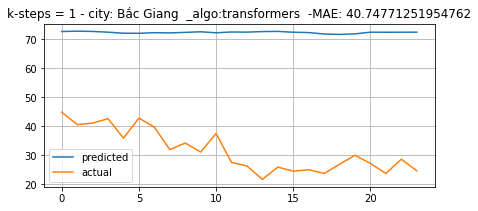

City: Bắc Giang  _algo:transformers  -MAE: 38.45141885250013


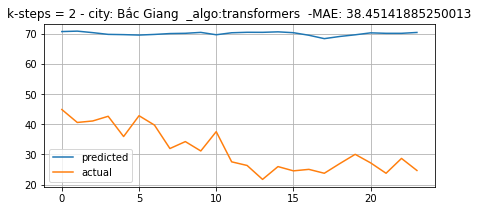

City: Bắc Giang  _algo:transformers  -MAE: 31.744458420656898


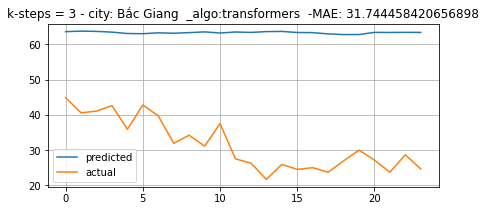

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 25.304897878079576


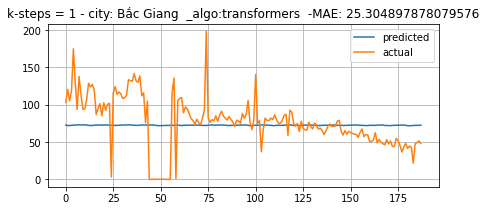

City: Bắc Giang  _algo:transformers  -MAE: 25.681966672367817


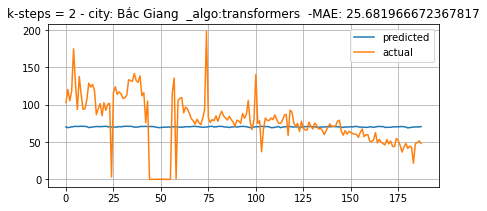

City: Bắc Giang  _algo:transformers  -MAE: 27.850669969475348


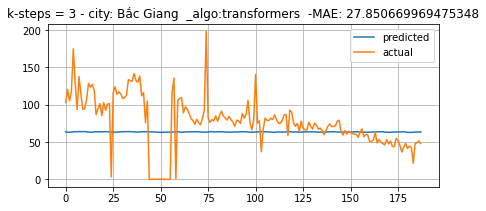

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/300 - train_loss: 1.3086 - test_loss: 0.767333
Epoch: 75/300 - train_loss: 0.2944 - test_loss: 0.409054
Epoch: 150/300 - train_loss: 0.2956 - test_loss: 0.432034
Epoch: 225/300 - train_loss: 0.2996 - test_loss: 0.445597
Epoch: 299/300 - train_loss: 0.2976 - test_loss: 0.446695
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 40.06025809757907


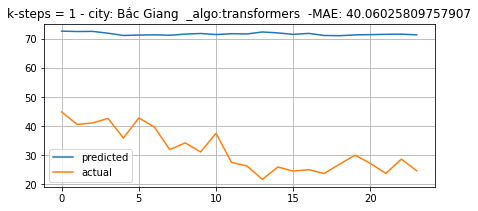

City: Bắc Giang  _algo:transformers  -MAE: 24.992116904268148


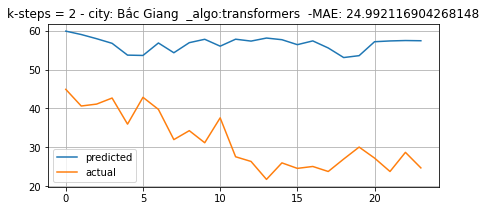

City: Bắc Giang  _algo:transformers  -MAE: 22.980518896712017


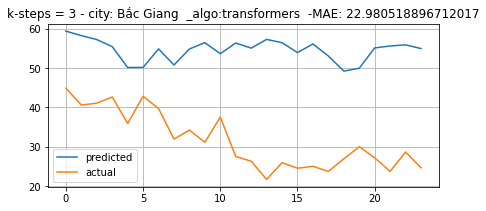

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 25.055866037039056


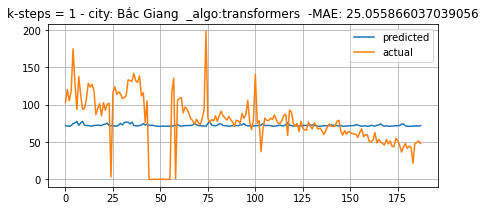

City: Bắc Giang  _algo:transformers  -MAE: 29.641409779295596


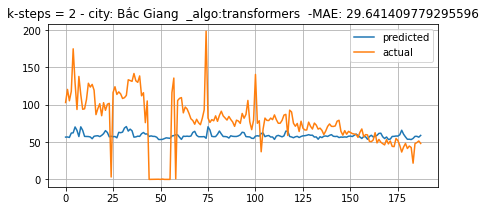

City: Bắc Giang  _algo:transformers  -MAE: 30.03833278060429


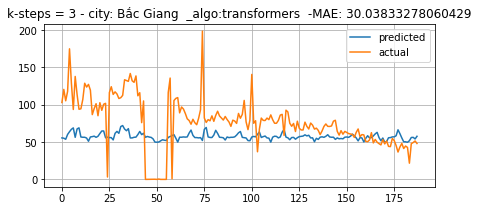

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/300 - train_loss: 1.2695 - test_loss: 0.869123
Epoch: 75/300 - train_loss: 0.2964 - test_loss: 0.481250
Epoch: 150/300 - train_loss: 0.2972 - test_loss: 0.425620
Epoch: 225/300 - train_loss: 0.2973 - test_loss: 0.431655
Epoch: 299/300 - train_loss: 0.2966 - test_loss: 0.418353
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 37.78650421120187


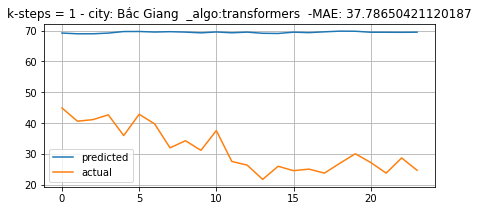

City: Bắc Giang  _algo:transformers  -MAE: 39.49163131264003


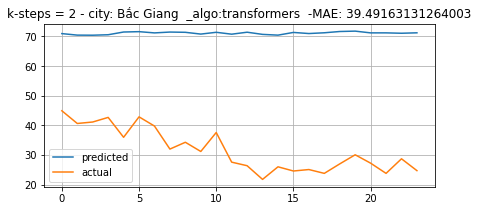

City: Bắc Giang  _algo:transformers  -MAE: 39.435675244717046


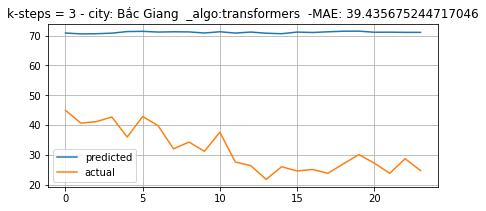

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 26.208751090956827


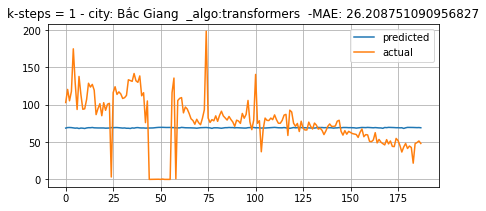

City: Bắc Giang  _algo:transformers  -MAE: 25.86856580481535


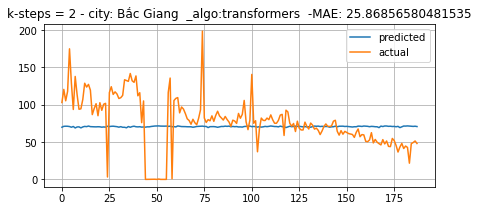

City: Bắc Giang  _algo:transformers  -MAE: 25.823733080645752


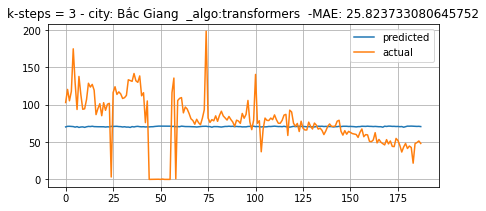

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/300 - train_loss: 1.4045 - test_loss: 0.929404
Epoch: 75/300 - train_loss: 0.2984 - test_loss: 0.426351
Epoch: 150/300 - train_loss: 0.2943 - test_loss: 0.434906
Epoch: 225/300 - train_loss: 0.3005 - test_loss: 0.416130
Epoch: 299/300 - train_loss: 0.2936 - test_loss: 0.433465
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 32.96070137430433


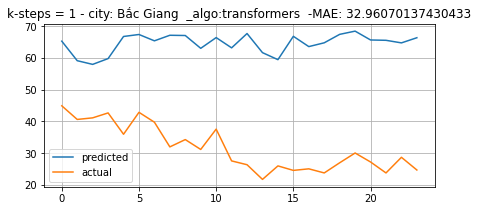

City: Bắc Giang  _algo:transformers  -MAE: 33.41108013742613


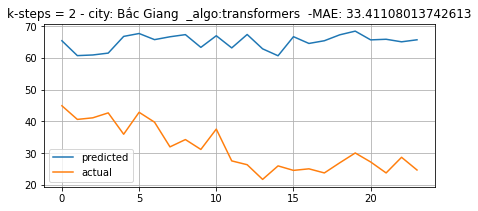

City: Bắc Giang  _algo:transformers  -MAE: 34.915243072996056


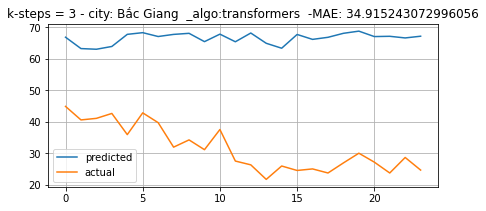

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 27.920125720569626


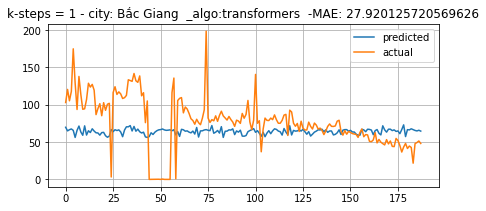

City: Bắc Giang  _algo:transformers  -MAE: 27.266205844287374


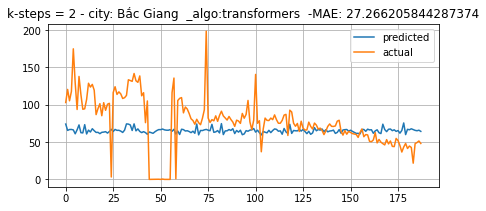

City: Bắc Giang  _algo:transformers  -MAE: 26.96389020509006


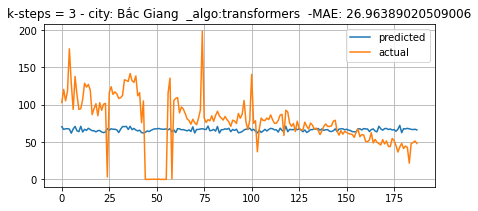

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/300 - train_loss: 1.5401 - test_loss: 0.809715
Epoch: 75/300 - train_loss: 0.2967 - test_loss: 0.423031
Epoch: 150/300 - train_loss: 0.2984 - test_loss: 0.430235
Epoch: 225/300 - train_loss: 0.2962 - test_loss: 0.434683
Epoch: 299/300 - train_loss: 0.2994 - test_loss: 0.424540
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 34.83498785194717


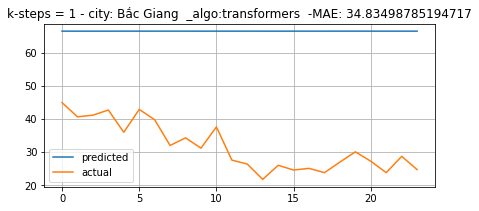

City: Bắc Giang  _algo:transformers  -MAE: 33.922244527203326


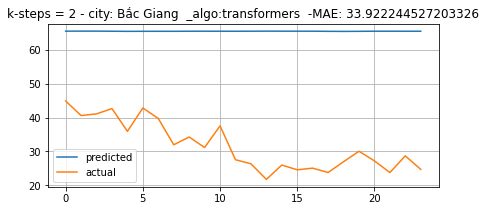

City: Bắc Giang  _algo:transformers  -MAE: 31.27585809804731


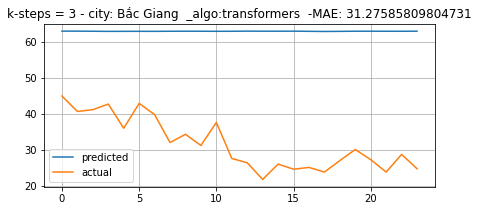

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 26.858063162816958


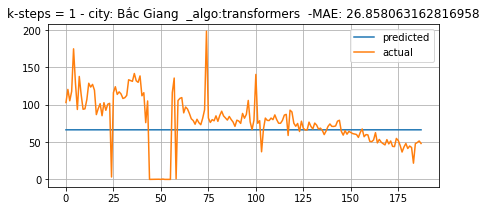

City: Bắc Giang  _algo:transformers  -MAE: 27.167719992374966


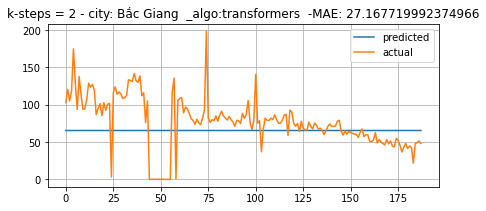

City: Bắc Giang  _algo:transformers  -MAE: 28.198156524279444


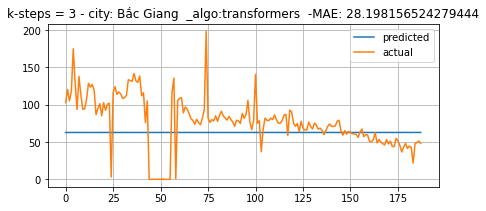

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/480 - train_loss: 0.8860 - test_loss: 0.611462
Epoch: 120/480 - train_loss: 0.3640 - test_loss: 0.174556
Epoch: 240/480 - train_loss: 0.3610 - test_loss: 0.184321
Epoch: 360/480 - train_loss: 0.3599 - test_loss: 0.178271
Epoch: 479/480 - train_loss: 0.3572 - test_loss: 0.172585
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 22.116158915756206


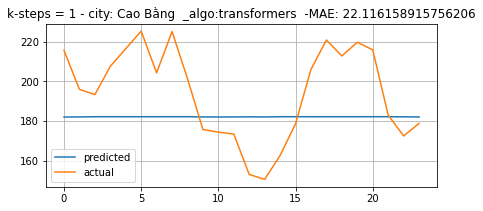

City: Cao Bằng  _algo:transformers  -MAE: 20.146010007404815


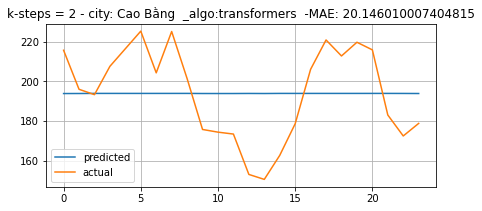

City: Cao Bằng  _algo:transformers  -MAE: 19.97717417218072


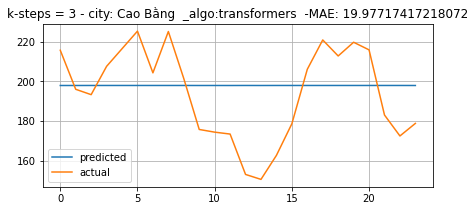

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 90.5687629624782


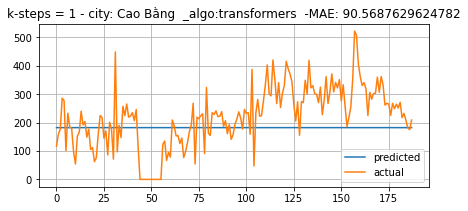

City: Cao Bằng  _algo:transformers  -MAE: 86.97260487965367


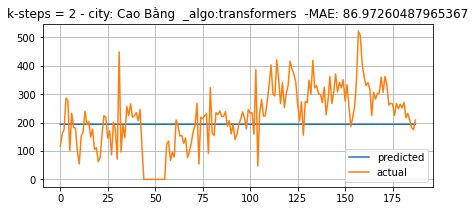

City: Cao Bằng  _algo:transformers  -MAE: 85.99044157623254


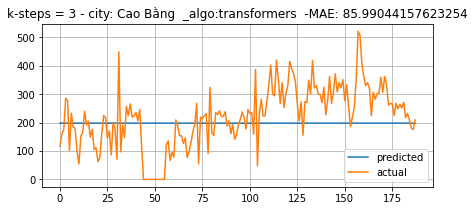

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/480 - train_loss: 1.1987 - test_loss: 0.679596
Epoch: 120/480 - train_loss: 0.3663 - test_loss: 0.172420
Epoch: 240/480 - train_loss: 0.3617 - test_loss: 0.175800
Epoch: 360/480 - train_loss: 0.3689 - test_loss: 0.175875
Epoch: 479/480 - train_loss: 0.3588 - test_loss: 0.178527
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 19.979593375220805


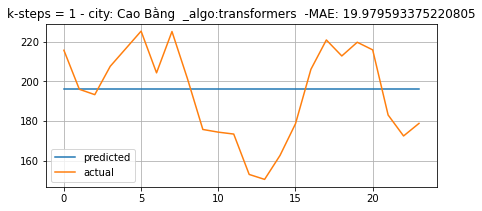

City: Cao Bằng  _algo:transformers  -MAE: 19.979592025145795


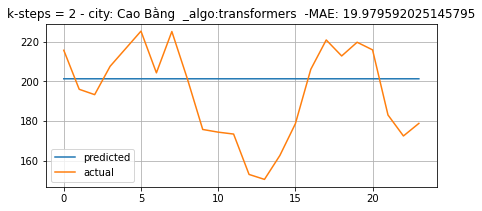

City: Cao Bằng  _algo:transformers  -MAE: 21.187600658899353


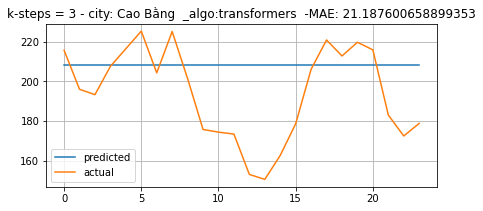

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 86.42216724268327


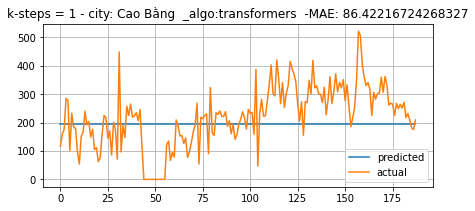

City: Cao Bằng  _algo:transformers  -MAE: 85.1680702736682


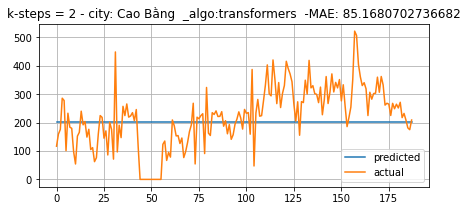

City: Cao Bằng  _algo:transformers  -MAE: 83.61655168948614


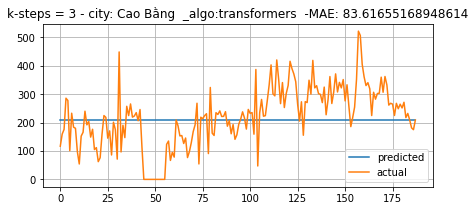

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/480 - train_loss: 0.8488 - test_loss: 0.580285
Epoch: 120/480 - train_loss: 0.3685 - test_loss: 0.178118
Epoch: 240/480 - train_loss: 0.3655 - test_loss: 0.165938
Epoch: 360/480 - train_loss: 0.3585 - test_loss: 0.171741
Epoch: 479/480 - train_loss: 0.3597 - test_loss: 0.174539
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 19.979200677057012


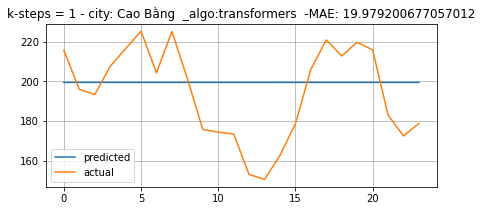

City: Cao Bằng  _algo:transformers  -MAE: 19.97901128068973


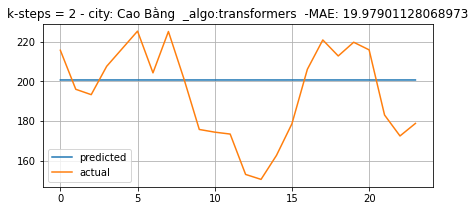

City: Cao Bằng  _algo:transformers  -MAE: 19.97898504552487


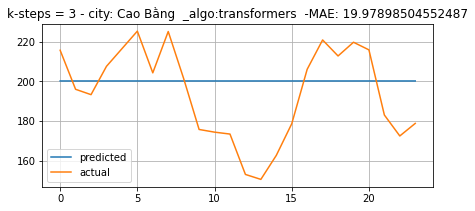

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 85.61553015123394


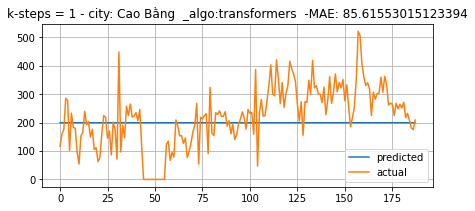

City: Cao Bằng  _algo:transformers  -MAE: 85.31270679958945


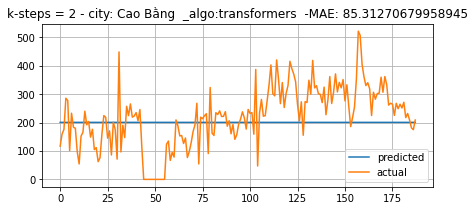

City: Cao Bằng  _algo:transformers  -MAE: 85.43548762172611


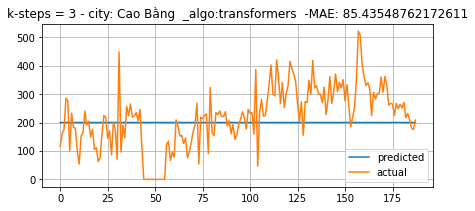

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/480 - train_loss: 1.3044 - test_loss: 0.709046
Epoch: 120/480 - train_loss: 0.3706 - test_loss: 0.192042
Epoch: 240/480 - train_loss: 0.3602 - test_loss: 0.175166
Epoch: 360/480 - train_loss: 0.3549 - test_loss: 0.175754
Epoch: 479/480 - train_loss: 0.3574 - test_loss: 0.170091
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 20.052637234746268


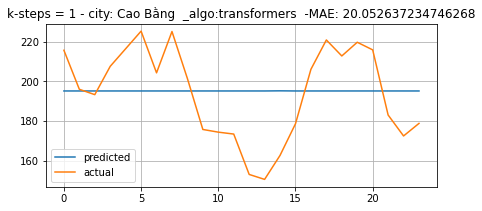

City: Cao Bằng  _algo:transformers  -MAE: 21.309192403098606


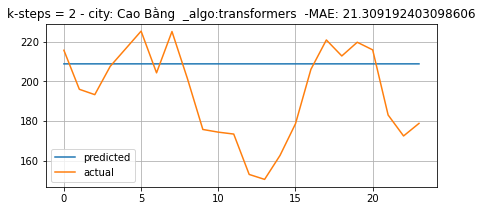

City: Cao Bằng  _algo:transformers  -MAE: 19.982914347476637


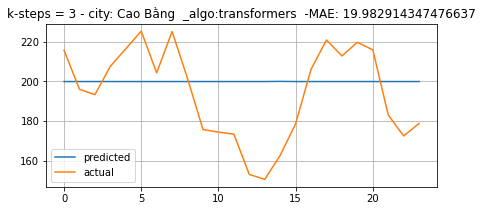

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 86.66908853202398


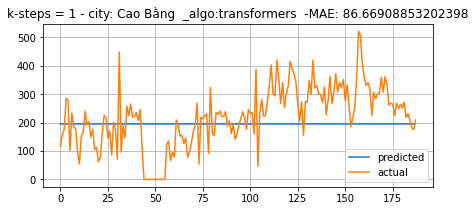

City: Cao Bằng  _algo:transformers  -MAE: 83.546319549279


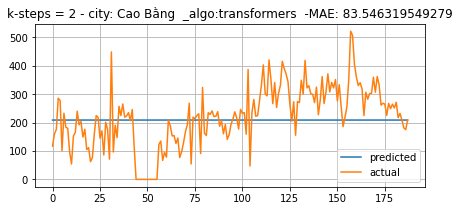

City: Cao Bằng  _algo:transformers  -MAE: 85.50520905939669


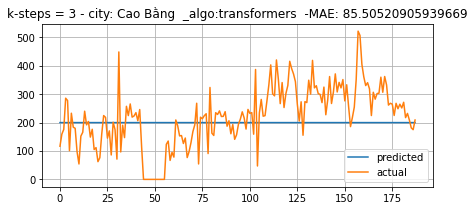

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/480 - train_loss: 0.9417 - test_loss: 0.644736
Epoch: 120/480 - train_loss: 0.3620 - test_loss: 0.173958
Epoch: 240/480 - train_loss: 0.3555 - test_loss: 0.182720
Epoch: 360/480 - train_loss: 0.3559 - test_loss: 0.169411
Epoch: 479/480 - train_loss: 0.3621 - test_loss: 0.173203
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 20.846364836254057


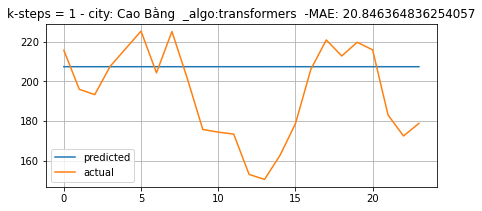

City: Cao Bằng  _algo:transformers  -MAE: 20.315518624843307


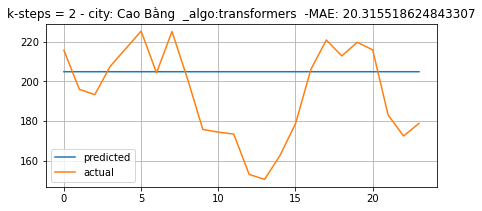

City: Cao Bằng  _algo:transformers  -MAE: 20.987807699079028


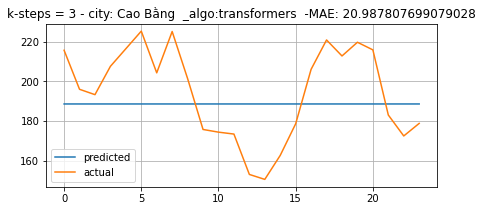

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 83.82164254528128


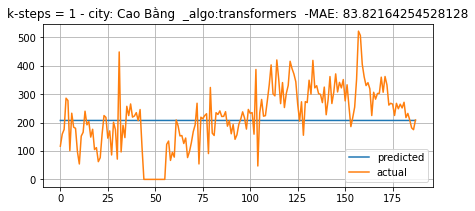

City: Cao Bằng  _algo:transformers  -MAE: 84.34465243351204


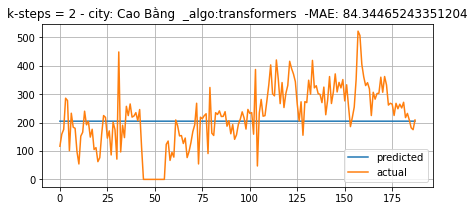

City: Cao Bằng  _algo:transformers  -MAE: 88.47595525081032


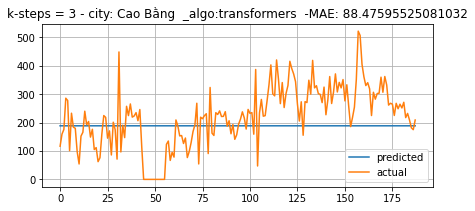

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/360 - train_loss: 1.4459 - test_loss: 0.924093
Epoch: 90/360 - train_loss: 0.2230 - test_loss: 0.187025
Epoch: 180/360 - train_loss: 0.2244 - test_loss: 0.182318
Epoch: 270/360 - train_loss: 0.2223 - test_loss: 0.209068
Epoch: 359/360 - train_loss: 0.2257 - test_loss: 0.211172
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 25.849642607477943


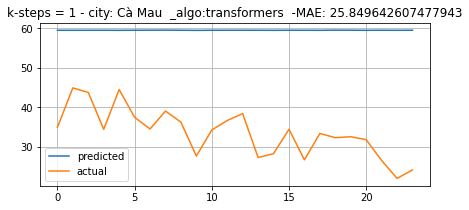

City: Cà Mau  _algo:transformers  -MAE: 16.125862600468096


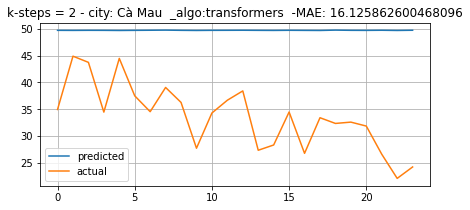

City: Cà Mau  _algo:transformers  -MAE: 19.349195009381535


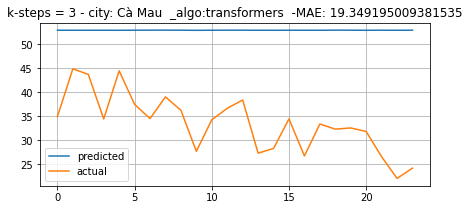

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 20.256595811539974


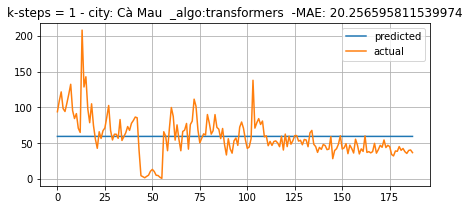

City: Cà Mau  _algo:transformers  -MAE: 20.31991078440853


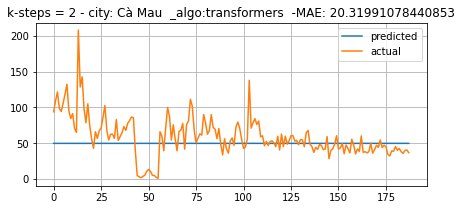

City: Cà Mau  _algo:transformers  -MAE: 19.9084356636354


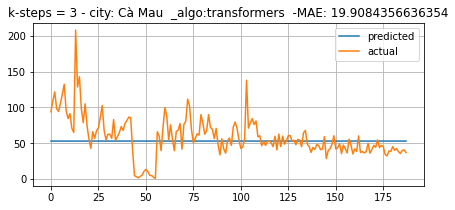

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/360 - train_loss: 1.0446 - test_loss: 0.875039
Epoch: 90/360 - train_loss: 0.2239 - test_loss: 0.230171
Epoch: 180/360 - train_loss: 0.2243 - test_loss: 0.208218
Epoch: 270/360 - train_loss: 0.2226 - test_loss: 0.193256
Epoch: 359/360 - train_loss: 0.2200 - test_loss: 0.204723
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 20.393300085266187


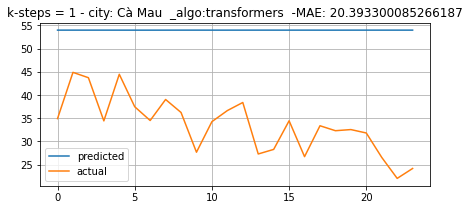

City: Cà Mau  _algo:transformers  -MAE: 22.976790000196033


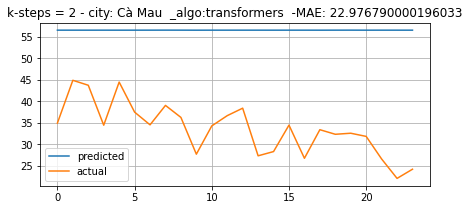

City: Cà Mau  _algo:transformers  -MAE: 19.117623790145746


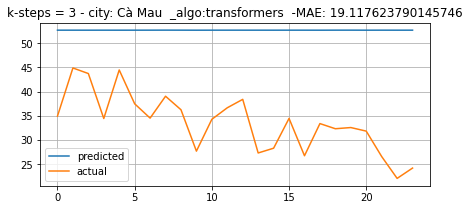

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 19.833002011781165


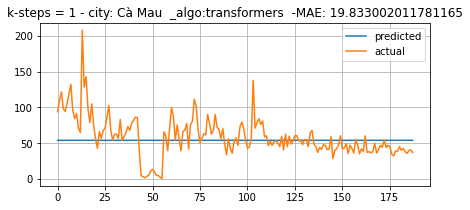

City: Cà Mau  _algo:transformers  -MAE: 19.887757870709663


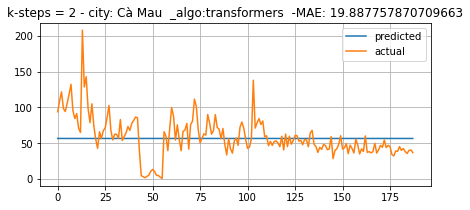

City: Cà Mau  _algo:transformers  -MAE: 19.93111067321353


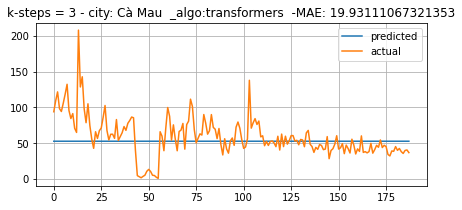

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/360 - train_loss: 1.2472 - test_loss: 0.780656
Epoch: 90/360 - train_loss: 0.2225 - test_loss: 0.197869
Epoch: 180/360 - train_loss: 0.2201 - test_loss: 0.191327
Epoch: 270/360 - train_loss: 0.2270 - test_loss: 0.206222
Epoch: 359/360 - train_loss: 0.2214 - test_loss: 0.195927
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 20.99995553569702


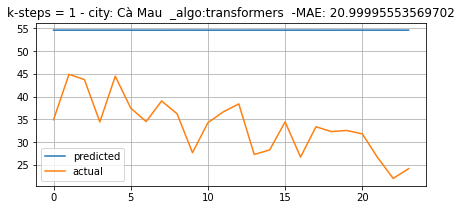

City: Cà Mau  _algo:transformers  -MAE: 24.362417134794637


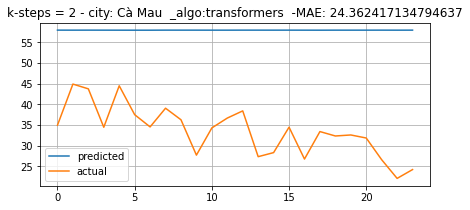

City: Cà Mau  _algo:transformers  -MAE: 16.812641319619775


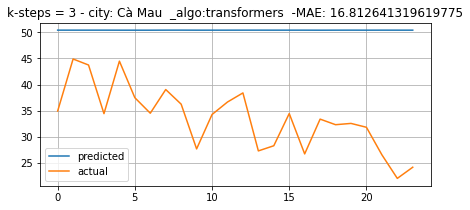

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 19.813131238142397


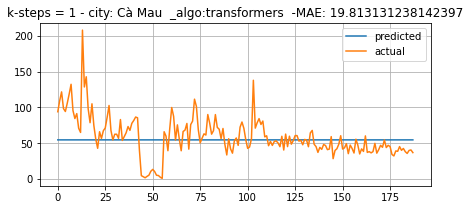

City: Cà Mau  _algo:transformers  -MAE: 20.053841224910204


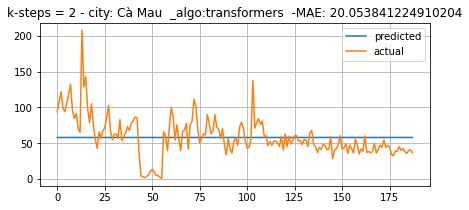

City: Cà Mau  _algo:transformers  -MAE: 20.21940679536766


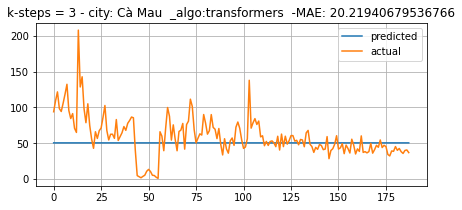

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/360 - train_loss: 1.1880 - test_loss: 0.701634
Epoch: 90/360 - train_loss: 0.2211 - test_loss: 0.211970
Epoch: 180/360 - train_loss: 0.2219 - test_loss: 0.205266
Epoch: 270/360 - train_loss: 0.2237 - test_loss: 0.203594
Epoch: 359/360 - train_loss: 0.2312 - test_loss: 0.195601
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 19.402833793524387


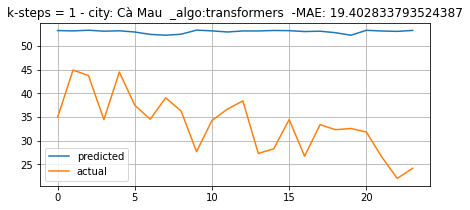

City: Cà Mau  _algo:transformers  -MAE: 21.0219840364196


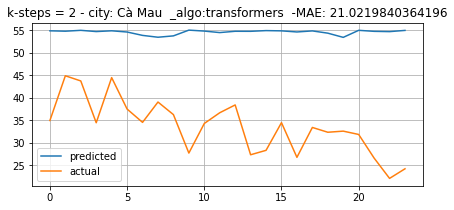

City: Cà Mau  _algo:transformers  -MAE: 17.760145553505758


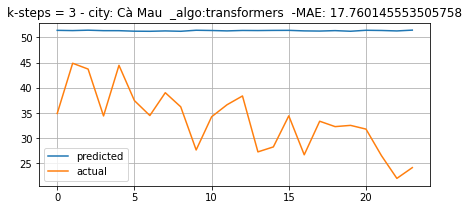

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 20.085740341243763


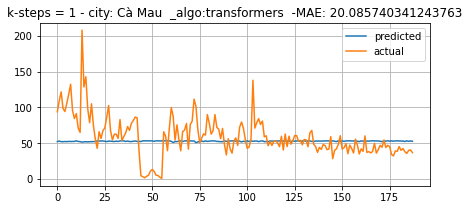

City: Cà Mau  _algo:transformers  -MAE: 20.017762692114424


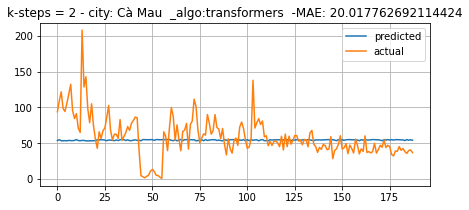

City: Cà Mau  _algo:transformers  -MAE: 20.137902532856646


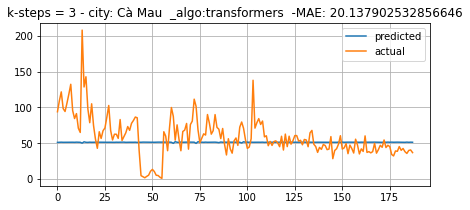

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/360 - train_loss: 1.1964 - test_loss: 0.689478
Epoch: 90/360 - train_loss: 0.2238 - test_loss: 0.199364
Epoch: 180/360 - train_loss: 0.2221 - test_loss: 0.213313
Epoch: 270/360 - train_loss: 0.2207 - test_loss: 0.190840
Epoch: 359/360 - train_loss: 0.2219 - test_loss: 0.193317
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 14.785234144569058


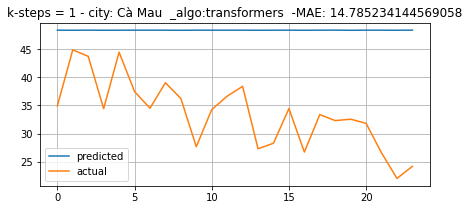

City: Cà Mau  _algo:transformers  -MAE: 13.645622754487135


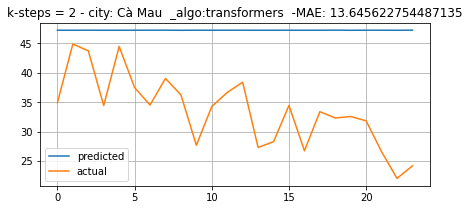

City: Cà Mau  _algo:transformers  -MAE: 21.380214990946047


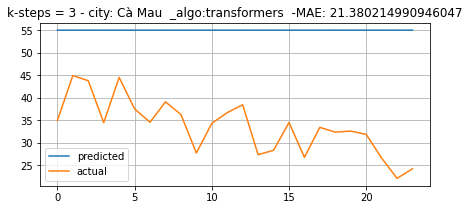

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 20.551406908991446


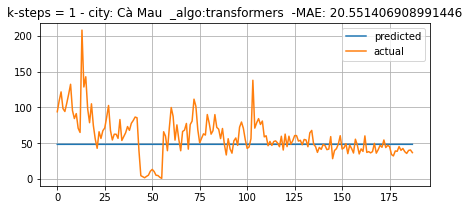

City: Cà Mau  _algo:transformers  -MAE: 20.80940680314488


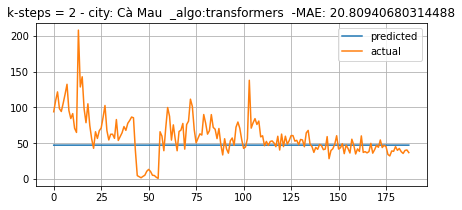

City: Cà Mau  _algo:transformers  -MAE: 19.814688806207744


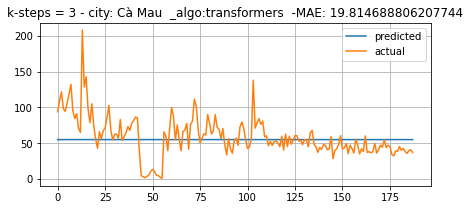

kết thúc train trong: 68
danh sách error city: 
{}


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-d41d1207ebdd>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

In [21]:
dt_started = datetime.now()
################################################
## Main run all city for Transformer
################################################
n_LoopEachExpRun = 5
expRuntime = 0 # basicly just increase each time


# 'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định', 'Đà Nẵng'
# 'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',

# 'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
# 'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',

# 'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng', 'Đắk Nông'
# 'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',

# 'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi', 'Đắk Lắk'
# 'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',

# 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh', 'Đồng Tháp'
# 'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',


l_errCity = {}
# Với mỗi thành phố ta sẽ chạy n_LoopEachExpRun lần ứng với từng giải thuật.
# Nếu chỉ chạy 1 lần thì để n_LoopEachExpRun = 0

for city in cities:
  try:
    
    total_result = pd.DataFrame() # final result cho mỗi thành phố of all runninng time
    total_metrix_result = pd.DataFrame() # final metrix result cho mỗi thành phố of all runninng time
    mix_train_test_result_tf=pd.DataFrame()

    for interation in range(n_LoopEachExpRun):
      
      # Pre-process data
      specific_data = get_city_data(fix_text(city))
      specific_data = impute_missing_value(specific_data)
      specific_data = convert_to_stationary(specific_data)
      specific_data.dropna(inplace=True)
      
      # Get right optimize parame
      n_layers, hidden_size, _, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name(algo='transformer', city=city)
      
      train, test = split_data(specific_data,lookback_window)

      # Fit data scaler to training data
      full_scaler = MinMaxScaler().fit(train)
      y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))

      # Scale train and test data
      train = full_scaler.transform(train)
      test = full_scaler.transform(test)

      # Get data to run model
      important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, specific_data)

      # Overwrite parameters for province-specific diarrhoea prediction
      args.look_back = lookback_window
      print(city)
      trainer = Trainer(
                      model_type='transformers',
                      city = city, 
                      learning_rate=learning_rate,
                      important_features=important_features,
                      train_loader=train_loader,
                      test_tensor=test_tensor,
                      n_layers=n_layers,
                      hidden_size=hidden_size,
                      dropout=dropout)

      # Train model with province-specific epochs
      trainer.train(epochs=epoch)

      print("Evaluate on test set: ")
      y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= True, scaled=True, city=city, y_scaler= y_scaler)

      print("Evaluate on train set: ")
      y_true_train, y_pred_train,  _, _, _, = trainer.evaluate_model(np_data=train, plot=True, scaled=True, city=city, y_scaler= y_scaler)

      # Lưu tất cả kết quả predicted train và predicted test
      mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer', specific_data, y_pred_test, 
                                                                              y_pred_train,lookback_window,interation, rmse_list[0],mae_list[0],mape_list[0])) 


      transformer_reslt = pd.DataFrame({
                                'City': city,
                                'Alg_name': 'transformers',
                                'Run Seq': interation,
                                'Observed': y_true_test[0], 
                                '1-month': y_pred_test[0], 
                                '2-months': y_pred_test[1],
                                '3-months': y_pred_test[2],
                                'RMSE_1-month': rmse_list[0],
                                'RMSE_2-month': rmse_list[1],
                                'RMSE_3-month': rmse_list[2],
                                'MAE_1-month': mae_list[0],
                                'MAE_2-month': mae_list[1],
                                'MAE_3-month': mae_list[2],
                                'MAPE_1-month': mape_list[0],
                                'MAPE_2-month': mape_list[1],
                                'MAPE_3-month': mape_list[2]})

      transformer_metrix_reslt = pd.DataFrame({
                                'City': city,
                                'Alg_name': 'transformers',
                                'Run Seq': interation,                          
                                'RMSE_1-month': rmse_list[0],
                                'RMSE_2-month': rmse_list[1],
                                'RMSE_3-month': rmse_list[2],
                                'MAE_1-month': mae_list[0],
                                'MAE_2-month': mae_list[1],
                                'MAE_3-month': mae_list[2],
                                'MAPE_1-month': mape_list[0],
                                'MAPE_2-month': mape_list[1],
                                'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0
      
      total_result = total_result.append(pd.DataFrame(transformer_reslt))
      total_metrix_result = total_metrix_result.append(pd.DataFrame(transformer_metrix_reslt))
    
    # Lưu xuống file excel ứng với từng thành phố
    total_result.to_excel(path+'/tf/diarrhoea_transformer_'+city+'_'+str(expRuntime)+'.xlsx')  
    total_metrix_result.to_excel(path_metrix+'/diarrhoea_metrix_transformer_'+city+'_'+str(expRuntime)+'.xlsx')
    
    # Lưu xuống mix predicted train và test data ứng với từng thành phố/ từng giải thuật
    save_results(mix_train_test_result_tf,'tf', city)
  except Exception as e:
    l_errCity[city] = e
    break

dt_ended = datetime.now()
print('kết thúc train trong:', round((dt_ended - dt_started).total_seconds()/60))
print ('danh sách error city: ')
print(l_errCity)

In [22]:
# import requests

# def send_to_telegram(message):

#     apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
#     chatID = '@ptn_announcement'
#     apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

#     try:
#         response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
#         print(response.text)
#     except Exception as e:
#         print(e)

# send_to_telegram("train tf for ensemble _ntry =5 _test" )